# Skane
# Kronoberg


![My Image](./Map-of-Sweden-showing-the-21-administrative-regions-adapted-from-SCB-2007.png)


In [1]:
#importing modules
from math import *
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 21})
import scipy.stats as stats
from scipy.optimize import curve_fit,leastsq
from scipy.integrate import odeint, ode
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

# 1. DATA preprocessing

In [2]:
#Parameters
n=20
starting_week = 10-4 #start week
first_case = 9
T_max = 48 #length of prediction
pv = 0.023 #fraction of infected that are admitted
rho = 7*1/5.1 #latency period
gamma = 7*1/5 #recovery rate
delay = 3 #2.5 #delay from infection to admission

In [3]:
file = pd.read_excel('../data/statistik-covid19-inskrivna_v2.xlsx', sheet_name = "Inskrivna i slutenvård")
data = [['Sthlm',           8, 2389923, 'SE-AB',  6524],
        ['VGR',             9, 1725881,  'SE-O', 23800],
        ['Skåne',          10, 1387650,  'SE-M', 10968],
        ['Östergötland',   11,  467095,  'SE-E', 10559],
        ['Jönköping',      12,  364750,  'SE-F',  8190],
        ['Södermanland',   13,  299101,  'SE-D', 10437],
        ['Uppsala',        14,  387628,  'SE-C',  5427],
        ['Gävleborg',      15,  287660,  'SE-X',  8504],
        ['Västmanland',    16,  277074,  'SE-U',  6075],
        ['Örebro',         17,  305726,  'SE-T', 28029],
        ['Norrbotten',     18,  249768, 'SE-BD', 18118],
        ['Dalarna',        19,  287806,  'SE-W', 17519],
        ['Västernorrland', 20,  244855,  'SE-Y',  5118],
        ['Värmland',       21,  282840,  'SE-S', 54665],
        ['Halland',        22,  336132,  'SE-N', 97239],
        ['Kalmar',         23,  245992,  'SE-H', 11165],
        ['Kronoberg',      24,  202163,  'SE-G', 21549],
        ['Västerbotten',   25,  273061,  'SE-AC', 8424],
        ['Jämtland',       26,  130972,  'SE-Z',  2931],
        ['Blekinge',       27,  159349,  'SE-K', 48935],
        ['Gotland',        28,   60106,  'SE-I',  3135]] 
regions = pd.DataFrame(data, columns = ['region', 'index','population', 'regionkod', 'area']) 
regions['density'] = regions['population']/regions['area']
first_cases = first_case*np.ones(21).astype(int) #week number when first case was recorded
regions['first case'] = first_cases
starting_weeks = first_cases - 3

regions.drop(regions.index[[20]],inplace=True) #remove Gotland


In [4]:
def getData(name, first_case):
    temp = regions.loc[regions['region'] == name] #find the right row
    index = temp['index'].values #find the region index
    N = temp['population'].values[0] #find population size of region
    R = file.iloc[index[0]] 
    R = R.replace(' ', 0) #replace missing data with 0
    R = R.replace('X', 0) 
    R = R.replace('IU', 0) 
    
    ind = np.arange(3, len(R), 2) 
    I = R.iloc[ind].values #extract admissions
    I = I[:-2] #remove last (incomplete) data point
    padding = np.zeros(10 - first_case + 3) 
    I = np.insert(I, 0, padding) 
    veckor = np.arange(0, len(I), 1) #create array of week numbers
    
    return I,veckor,N


#Load Google mobility data
def loadMobility(name, starting_week):
    df = pd.read_csv('../data/2020_SE_Region_Mobility_Report.csv') 
    temp = regions.loc[regions['region'] == name] 
    code = temp['regionkod'].values 
    temp2 = df.loc[df['iso_3166_2_code'] == code[0]]
    transit = temp2['transit_stations_percent_change_from_baseline'].values 
    dagar = np.arange(46, 46 + len(transit))
    tv = np.ceil(dagar / 7)
    
    
    gveckor = np.unique(tv)
    k = 0
    Tr = np.zeros(int(max(gveckor) - min(gveckor))+1)

    for i in gveckor:
        ind=tv==i
        Tr[k]=np.mean(transit[ind])/100
        k=k+1
    for i in range(1,len(Tr)):
        if np.isnan(Tr[i]):
            Tr[i]=Tr[i-1]
    #print(Tr)
    init=0.2 #set base line travel
    Tr[0:2]=[init,init]
    #print(Tr)
    #print(gveckor)
    #print(gveckor-svecka)
    Trfkn = interp1d(gveckor-starting_week, Tr, kind = "linear", fill_value = "extrapolate")
    #print(Tr)
    return Trfkn

In [5]:
def loadMobility_list(name_list, starting_week):
    Trfkn_dict = dict()
    for i in name_list:
       Trfkn_dict[i] = loadMobility(i, starting_week) 
    return Trfkn_dict


def getData_list(name_list, first_case):
    getData_dict = dict()
    for i in name_list:
        I, veckor, N = getData(i, first_case)
        getData_dict[i] =  {'I': I, 'veckor': veckor, 'N': N}
    return getData_dict

# 2. Correlation Analysis

In [6]:
name_list = regions.region.tolist()
Trfkn_dict = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 

In [7]:
region_name = ['Sthlm']
df = pd.DataFrame(getData_dict[region_name[0]]['I'])/regions[regions.region == region_name[0]].density.values

for j in getData_dict.keys():
    if j == region_name[0]:
        continue
    region_name.append(j)
    df_temp = pd.DataFrame(getData_dict[j]['I'])
  
    df_temp = df_temp/regions[regions.region ==j].density.values
    df = pd.concat([df,df_temp], axis = 1)
 

In [8]:
df.columns = region_name
df.head()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.101002,0.124111,0.0,0.0,0.0,0.0,0.056002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df.corr()

,Sthlm,VGR,Skåne,Östergötland,Jönköping,Södermanland,Uppsala,Gävleborg,Västmanland,Örebro,Norrbotten,Dalarna,Västernorrland,Värmland,Halland,Kalmar,Kronoberg,Västerbotten,Jämtland,Blekinge
Sthlm,1.000000,0.843206,0.707943,0.968330,0.911792,0.912002,0.906437,0.851443,0.919852,0.608364,0.916373,0.942713,0.767337,0.609362,0.797345,0.845498,0.634756,0.777421,0.834126,0.277613
VGR,0.843206,1.000000,0.887548,0.728929,0.583918,0.913086,0.903484,0.892073,0.902264,0.570380,0.880070,0.705631,0.886026,0.854733,0.793608,0.925145,0.855745,0.805349,0.664991,0.540573
Skåne,0.707943,0.887548,1.000000,0.621677,0.400992,0.826470,0.836551,0.770706,0.844795,0.357385,0.694584,0.537343,0.825453,0.701450,0.634010,0.837116,0.895035,0.708041,0.714445,0.703238
Östergötland,0.968330,0.728929,0.621677,1.000000,0.949446,0.843867,0.836592,0.758317,0.858380,0.558964,0.861616,0.937252,0.634197,0.456047,0.695051,0.749121,0.519094,0.666688,0.848179,0.214819
Jönköping,0.911792,0.583918,0.400992,0.949446,1.000000,0.742007,0.728714,0.634586,0.728252,0.546562,0.769218,0.934666,0.496379,0.328326,0.611534,0.626122,0.309441,0.592080,0.726492,0.029500
Södermanland,0.912002,0.913086,0.826470,0.843867,0.742007,1.000000,0.935397,0.890879,0.919812,0.666803,0.861836,0.819782,0.839591,0.734929,0.810330,0.888893,0.747598,0.818094,0.757545,0.496441
Uppsala,0.906437,0.903484,0.836551,0.836592,0.728714,0.935397,1.000000,0.834167,0.951433,0.563244,0.822067,0.805795,0.879517,0.724591,0.791194,0.910907,0.725122,0.833061,0.812731,0.496166
Gävleborg,0.851443,0.892073,0.770706,0.758317,0.634586,0.890879,0.834167,1.000000,0.888467,0.611241,0.894599,0.780226,0.822392,0.799760,0.880823,0.863245,0.827918,0.790691,0.698229,0.388709
Västmanland,0.919852,0.902264,0.844795,0.858380,0.728252,0.919812,0.951433,0.888467,1.000000,0.591124,0.874052,0.816632,0.876964,0.703475,0.832255,0.882670,0.768168,0.795805,0.850684,0.471452
Örebro,0.608364,0.570380,0.357385,0.558964,0.546562,0.666803,0.563244,0.611241,0.591124,1.000000,0.661141,0.610308,0.579358,0.611706,0.725711,0.523089,0.391109,0.514327,0.427815,0.262842


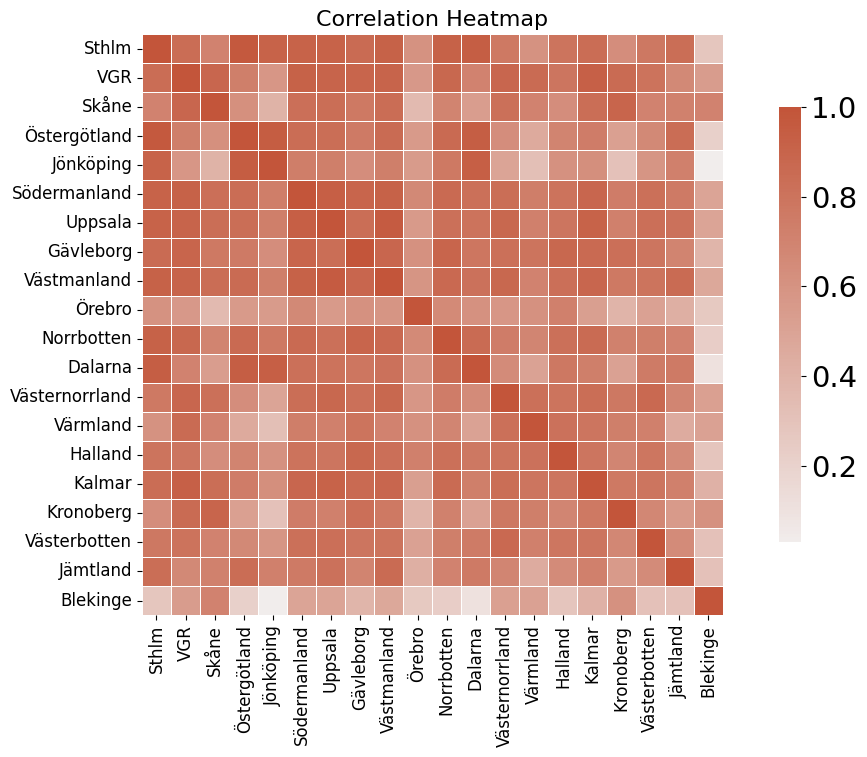

In [10]:
import seaborn as sns


corr = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(
    corr,
    cmap=cmap,
           # show correlation coefficients
    fmt=".2f",        # format for annotations
    linewidths=0.5,   # space between cells
    square=True,      # keep the cells square
    cbar_kws={"shrink": 0.75},  # color bar size
    center=0   ,
    annot_kws={"size": 8}       # center the colormap at zero
)

# Add title and tweak layout
plt.title('Correlation Heatmap', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig("../data/correlation_heatmap.svg", format="svg")

# Display the plot
plt.show()

In [11]:
df_Sthlm = pd.DataFrame(df.corr().loc['Sthlm']).sort_values(by = 'Sthlm', ascending=False)
df_Sthlm

,Sthlm
Sthlm,1.000000
Östergötland,0.968330
Dalarna,0.942713
Västmanland,0.919852
Norrbotten,0.916373
Södermanland,0.912002
Jönköping,0.911792
Uppsala,0.906437
Gävleborg,0.851443
Kalmar,0.845498


In [12]:
df_Skåne= pd.DataFrame(df.corr().loc['Skåne']).sort_values(by = 'Skåne', ascending=False)
df_Skåne

,Skåne
Skåne,1.000000
Kronoberg,0.895035
VGR,0.887548
Västmanland,0.844795
Kalmar,0.837116
Uppsala,0.836551
Södermanland,0.826470
Västernorrland,0.825453
Gävleborg,0.770706
Jämtland,0.714445


In [13]:
df_Uppsala= pd.DataFrame(df.corr().loc['Uppsala']).sort_values(by = 'Uppsala', ascending=False)
df_Uppsala

,Uppsala
Uppsala,1.000000
Västmanland,0.951433
Södermanland,0.935397
Kalmar,0.910907
Sthlm,0.906437
VGR,0.903484
Västernorrland,0.879517
Östergötland,0.836592
Skåne,0.836551
Gävleborg,0.834167


# 3. Modeling

#### S[Sthlm]=x0      

#### E[Sthlm]=x1       

#### I[Sthlm]=x2       

#### R[Sthlm]=x3

#### S[Södermanland]=x4      

#### E[Södermanland]=x5       

#### I[Södermanland]=x6       

#### R[Södermanland]=x7

In [15]:
name_list = ['Skåne', 'Kronoberg']
transit_fkn_dct = loadMobility_list(name_list, starting_week = 6) 
getData_dict = getData_list(name_list, first_case = 9) 
region_0 = name_list[0]
region_1 = name_list[1]
I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[region_0]['veckor'] 

def beta(t, a, b, transit_fkn):
    return a + b * transit_fkn(t)

def dx(x, t, N, a, b, c, lag):
    S0, E0, I0, R0, S1, E1, I1, R1 = x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]

    dS0 =  - S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1])
    dS1 =  - S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0])
    dE0 =    S0 * (beta(t-lag, a[0], b[0], transit_fkn_dct[region_0]) * I0/N[0] + c*I1/N[1]) - rho*E0
    dE1 =    S1 * (beta(t-lag, a[1], b[1], transit_fkn_dct[region_1]) * I1/N[1] + c*I0/N[0]) - rho*E1
    dI0 =  rho*E0 - gamma*I0
    dI1 =  rho*E1 - gamma*I1
    dR0 =  gamma*I0
    dR1 =  gamma*I1

    return [dS0, dE0, dI0, dR0,
            dS1, dE1, dI1, dR1]

def pred_inlagda(t, a1, b1, a2, b2, c, lag):
    N = [getData_dict[name_list[0]]['N'],
         getData_dict[name_list[1]]['N']]
    x0 = [N[0]-1, 0, 1, 0,
          N[1]-1, 0, 1, 0] #initial conditions
    x = odeint(dx, x0, t, args=(N, [a1, a2], [b1, b2], c, lag))
    return pv*x[:, [2, 6]]

In [16]:
getData_dict

{'Skåne': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 25, 44, 82, 97, 105, 107, 100, 94, 89,
         95, 86, 74, 79, 71, 55, 39, 37, 19, 33, 19, 16, 41, 25, 25, 19, 24,
         25, 23, 17, 32, 30, 47, 84, 120, 168, 156, 189, 205, 242],
        dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 1387650},
 'Kronoberg': {'I': array([0.0, 0.0, 0.0, 0.0, 0, 0, 0, 7, 0, 16, 22, 17, 28, 21, 18, 23, 22,
         15, 9, 13, 4, 5, 0, 0, 0, 8, 0, 4, 0, 0, 0, 0, 6, 7, 0, 10, 15, 12,
         23, 17, 29, 33, 31, 27, 37], dtype=object),
  'veckor': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
         34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]),
  'N': 202163}}

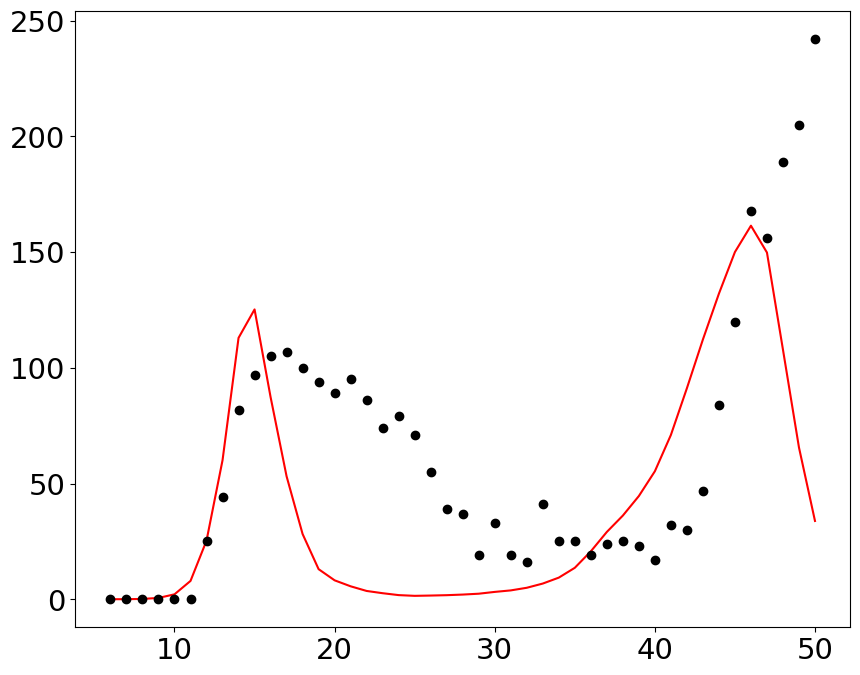

In [17]:
a = [3.662573, 2.997906 ] 
b = [8.139158,  6.992810]   
c = 0
P = pred_inlagda(weeks_train, a[0], b[0], a[1], b[1], c, delay)
fig, axes = plt.subplots(1, 1, figsize = (10, 8))
axes.plot(weeks_train+6, P[:,0], 'r', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[0], 'ko', label = "Inlagda")


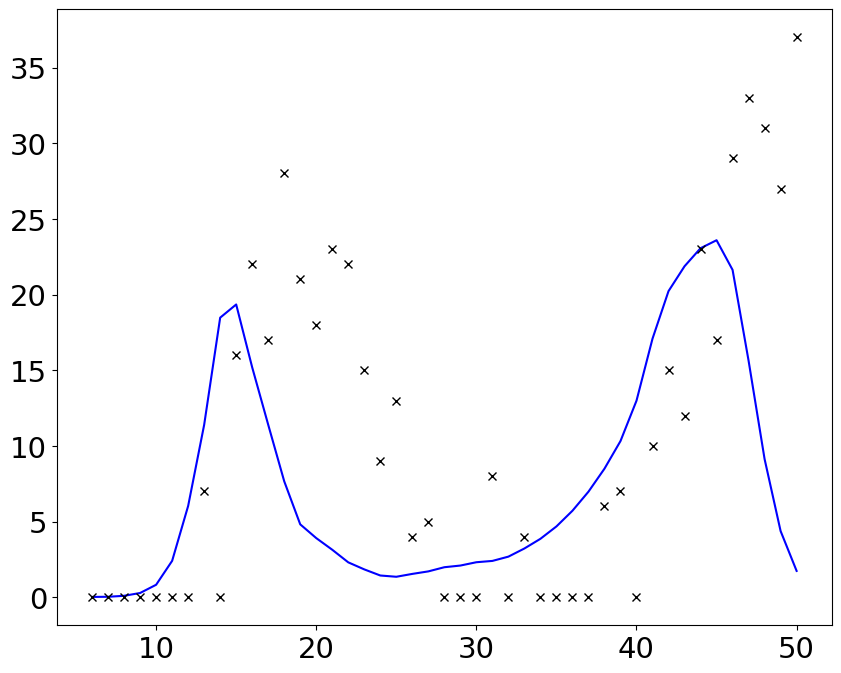

In [18]:
fig, axes = plt.subplots(1, 1, figsize = (10, 8))

axes.plot(weeks_train+6, P[:,1], 'b', label = "Prediktion med resor") 
axes.plot(weeks_train+6, I_train[1], 'kx', label = "Inlagda")

In [19]:
def return_RMSE(P, I):
    return np.sqrt(np.mean((P - I)**2))

def return_CV_RMSE(P, I):
    return 100 * return_RMSE(P, I) / np.mean(I)

In [20]:
print(return_RMSE(P[:,0], I_train[0]))
print(return_RMSE(P[:,1], I_train[1]))
print(return_CV_RMSE(P[:,0], I_train[0]))
print(return_CV_RMSE(P[:,1], I_train[1]))

57.15372023117821
11.250860350653582
90.62429212131852
105.69701790801903


In [47]:
#!pip install wandb


In [21]:
from tqdm import tqdm

name_list = ['Skåne', 'Kronoberg']
transit_fkn_dict = loadMobility_list(name_list, starting_week) 
getData_dict = getData_list(name_list, first_case)

I_train = [getData_dict[name_list[0]]['I'],
           getData_dict[name_list[1]]['I']]
weeks_train = getData_dict[name_list[0]]['veckor']  # getData_dict['Södermanland']['veckor'] == getData_dict['Sthlm']['veckor']

n=3
ah0 = np.linspace(3,10,n)
bh0 = np.linspace(4,10,n)
ah1 = np.linspace(3,10,n)
bh1 = np.linspace(4,10,n)
c = np.linspace(0,0.2,n)

E_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0),len(ah1), len(bh1), len(c)))

for i in tqdm(range(n)):
    for j in range(n):
        for k in range(n):
            for l in range(n): 
                for m in range(n):
                    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
                    
                    # Store the results in the arrays (instead of RMSE)
                    E_rmse0[i,j,k,l,m] = return_RMSE(P[:,0], I_train[0])
                    E_rmse1[i,j,k,l,m] = return_RMSE(P[:,1], I_train[1])  

                    # Store the results in the arrays (instead of cv-rms)
                    E_cv_rmse0[i, j, k, l, m] = return_CV_RMSE(P[:,0], I_train[0]) 
                    E_cv_rmse1[i, j, k, l, m] = return_CV_RMSE(P[:,1], I_train[1])

                                

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:19<00:00,  6.55s/it]


In [22]:
sweep_config = {
    'method': 'random'
    }

In [23]:
metric = {
    'name': 'CV_RMSE',
    'goal': 'minimize'   
    }

sweep_config['metric'] = metric

In [24]:
parameters_dict = {
    "ah0": {
        "min": 0,
        "max": 10,
        "distribution": "uniform"
    },
    "bh0": {
        "min": 0,
        "max": 10,
        "distribution": "uniform"
    },
    "ah1": {
        "min": 0,
        "max": 3,
        "distribution": "uniform"
    },
    "bh1": {
        "min": 0,
        "max": 10,
        "distribution": "uniform"
    },
    "c": {
        "min": 0,
        "max": 3,
        "distribution": "uniform"
    }
}

sweep_config['parameters'] = parameters_dict


In [25]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'CV_RMSE'},
 'parameters': {'ah0': {'distribution': 'uniform', 'max': 10, 'min': 0},
                'ah1': {'distribution': 'uniform', 'max': 3, 'min': 0},
                'bh0': {'distribution': 'uniform', 'max': 10, 'min': 0},
                'bh1': {'distribution': 'uniform', 'max': 10, 'min': 0},
                'c': {'distribution': 'uniform', 'max': 3, 'min': 0}}}


In [26]:
import wandb


In [27]:
sweep_id = wandb.sweep(sweep_config, project="sweeps-SEIR_Skåne_Kronoberg")

Create sweep with ID: yw5aij6r
Sweep URL: https://wandb.ai/danish2562022/sweeps-SEIR_Sk%C3%A5ne_Kronoberg/sweeps/yw5aij6r


In [28]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms


def fit_model(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config

        P = pred_inlagda(weeks_train, config.ah0, config.bh0, config.ah1, config.bh1, config.c, delay)
        CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
        CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
        CV_RMSE = CV_RMSE_1 + CV_RMSE_2
        RMSE_1 = return_RMSE(P[:,0], I_train[0])
        RMSE_2 = return_RMSE(P[:,1], I_train[1])
        RMSE = RMSE_1 + RMSE_2
        wandb.log({"CV_RMSE": CV_RMSE, "RMSE": RMSE,  "RMSE_skane": RMSE_1,  "RMSE_kronoberg": RMSE_2,  "CV_RMSE_'skane": CV_RMSE_1,  "CV_RMSE_kronoberg": CV_RMSE_2})  

In [ ]:
wandb.agent(sweep_id,fit_model, count=10000)

wandb: Agent Starting Run: o67u0d0b with config:
wandb: 	ah0: 5.218493128141949
wandb: 	ah1: 1.9705559146717435
wandb: 	bh0: 4.40223954077469
wandb: 	bh1: 4.9501905302540985
wandb: 	c: 2.2086283109587383
wandb: Currently logged in as: danish2562022. Use `wandb login --relogin` to force relogin


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4046.03595
CV_RMSE_'skane,2340.89073
CV_RMSE_kronoberg,1705.14522
RMSE,1657.82499
RMSE_kronoberg,181.50324


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q8zjerbs with config:
wandb: 	ah0: 5.2453518110360005
wandb: 	ah1: 1.7684184589541512
wandb: 	bh0: 8.66646525057156
wandb: 	bh1: 9.491761875021348
wandb: 	c: 0.27845624950104564


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1689.38584
CV_RMSE_'skane,1515.80365
CV_RMSE_kronoberg,173.58219
RMSE,974.44369
RMSE_kronoberg,18.47686


wandb: Agent Starting Run: 7vhivbpd with config:
wandb: 	ah0: 7.74442006898874
wandb: 	ah1: 1.4948771795968638
wandb: 	bh0: 1.32793116668118
wandb: 	bh1: 5.238422454055099
wandb: 	c: 1.8488016756163257


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4260.90552
CV_RMSE_'skane,2577.12572
CV_RMSE_kronoberg,1683.7798
RMSE,1804.53629
RMSE_kronoberg,179.22901


wandb: Agent Starting Run: b0qcc5os with config:
wandb: 	ah0: 6.155229184641118
wandb: 	ah1: 1.6637362909034574
wandb: 	bh0: 0.4245964533351143
wandb: 	bh1: 4.643345057461486
wandb: 	c: 2.962480770429348


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4471.35692
CV_RMSE_'skane,2534.63627
CV_RMSE_kronoberg,1936.72065
RMSE,1804.66376
RMSE_kronoberg,206.15315


wandb: Agent Starting Run: 2ifo7lf2 with config:
wandb: 	ah0: 1.9510648182926815
wandb: 	ah1: 2.8083372329413647
wandb: 	bh0: 0.1712902315534437
wandb: 	bh1: 6.245417318990829
wandb: 	c: 1.7771750432356457


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2752.73139
CV_RMSE_'skane,1587.76997
CV_RMSE_kronoberg,1164.96142
RMSE,1125.35726
RMSE_kronoberg,124.00367


wandb: Agent Starting Run: 9in5qy77 with config:
wandb: 	ah0: 2.0493392092807583
wandb: 	ah1: 2.2611816838922794
wandb: 	bh0: 4.075789336190468
wandb: 	bh1: 2.2974637435377856
wandb: 	c: 0.9350820750697696


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1692.70895
CV_RMSE_'skane,840.5914
CV_RMSE_kronoberg,852.11755
RMSE,620.83615
RMSE_kronoberg,90.70318


wandb: Agent Starting Run: wyqajylz with config:
wandb: 	ah0: 8.561902436248335
wandb: 	ah1: 0.4481447988507756
wandb: 	bh0: 2.839014455937199
wandb: 	bh1: 5.605449017260312
wandb: 	c: 0.3706656123178506


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2999.10833
CV_RMSE_'skane,2588.8117
CV_RMSE_kronoberg,410.29663
RMSE,1676.35104
RMSE_kronoberg,43.6738


wandb: Agent Starting Run: aa4y96xw with config:
wandb: 	ah0: 5.828871769291181
wandb: 	ah1: 2.196594653905662
wandb: 	bh0: 7.158212821797835
wandb: 	bh1: 3.676873838580341
wandb: 	c: 1.8405764577896775


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4158.68838
CV_RMSE_'skane,2397.62125
CV_RMSE_kronoberg,1761.06713
RMSE,1699.55562
RMSE_kronoberg,187.45581


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n72xco27 with config:
wandb: 	ah0: 2.0356671216404223
wandb: 	ah1: 0.7896862758629059
wandb: 	bh0: 0.3412061074938033
wandb: 	bh1: 7.707792044920284
wandb: 	c: 2.310664552338189


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2257.33166
CV_RMSE_'skane,1474.60047
CV_RMSE_kronoberg,782.7312
RMSE,1013.29875
RMSE_kronoberg,83.31739


wandb: Agent Starting Run: j85z18d3 with config:
wandb: 	ah0: 2.641977769370646
wandb: 	ah1: 2.419305633360122
wandb: 	bh0: 1.7378005405681929
wandb: 	bh1: 8.021943647347657
wandb: 	c: 2.0566762785803876


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2838.93026
CV_RMSE_'skane,1711.20297
CV_RMSE_kronoberg,1127.72729
RMSE,1199.23898
RMSE_kronoberg,120.0403


wandb: Agent Starting Run: 2r9wtgzd with config:
wandb: 	ah0: 0.17217383907468853
wandb: 	ah1: 2.5011133483247883
wandb: 	bh0: 2.0988946179807977
wandb: 	bh1: 8.27624914241396
wandb: 	c: 1.7129385379083737


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,944.31464
CV_RMSE_'skane,435.07493
CV_RMSE_kronoberg,509.23971
RMSE,328.59299
RMSE_kronoberg,54.20574


wandb: Agent Starting Run: a6jnex02 with config:
wandb: 	ah0: 5.879564576431422
wandb: 	ah1: 2.3824820239314315
wandb: 	bh0: 3.3570995953103933
wandb: 	bh1: 2.976727418210201
wandb: 	c: 1.4372926396802057


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3948.73133
CV_RMSE_'skane,2331.65153
CV_RMSE_kronoberg,1617.0798
RMSE,1642.62406
RMSE_kronoberg,172.12916


wandb: Agent Starting Run: pi5f3ij4 with config:
wandb: 	ah0: 3.7031031927591087
wandb: 	ah1: 0.2060118676921796
wandb: 	bh0: 7.446599677618073
wandb: 	bh1: 8.531421580932534
wandb: 	c: 1.1048329861739083


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,853.87423
CV_RMSE_'skane,642.23154
CV_RMSE_kronoberg,211.64269
RMSE,427.56221
RMSE_kronoberg,22.52819


wandb: Agent Starting Run: tahsnjnd with config:
wandb: 	ah0: 9.000055543105502
wandb: 	ah1: 0.35845543840838745
wandb: 	bh0: 8.01972582045291
wandb: 	bh1: 2.006323484290431
wandb: 	c: 0.41388002104185817


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3231.72604
CV_RMSE_'skane,2679.75126
CV_RMSE_kronoberg,551.97478
RMSE,1748.78444
RMSE_kronoberg,58.75465


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2xeypiwh with config:
wandb: 	ah0: 1.2030581944415153
wandb: 	ah1: 0.45136598508140713
wandb: 	bh0: 2.2628960547169106
wandb: 	bh1: 9.423678421342611
wandb: 	c: 2.798208676607038


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1376.3457
CV_RMSE_'skane,858.15034
CV_RMSE_kronoberg,518.19536
RMSE,596.36583
RMSE_kronoberg,55.15902


wandb: Agent Starting Run: qyjc8wyg with config:
wandb: 	ah0: 2.042353880417803
wandb: 	ah1: 2.7536663232342207
wandb: 	bh0: 8.931924883299352
wandb: 	bh1: 8.608851113669042
wandb: 	c: 0.9801643296349428


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,284.97822
CV_RMSE_'skane,126.97024
CV_RMSE_kronoberg,158.00798
RMSE,96.89497
RMSE_kronoberg,16.81907


wandb: Agent Starting Run: jzfq3kkz with config:
wandb: 	ah0: 2.15030630564555
wandb: 	ah1: 2.110669962634587
wandb: 	bh0: 6.797501773129774
wandb: 	bh1: 8.869869443275864
wandb: 	c: 1.0322398379553128


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,258.50299
CV_RMSE_'skane,122.6416
CV_RMSE_kronoberg,135.8614
RMSE,91.80766
RMSE_kronoberg,14.46169


wandb: Agent Starting Run: ug2a7h99 with config:
wandb: 	ah0: 1.4581467974040074
wandb: 	ah1: 2.944632616904383
wandb: 	bh0: 6.735819309881812
wandb: 	bh1: 3.723322212152627
wandb: 	c: 2.996444707637457


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3404.23961
CV_RMSE_'skane,1652.44976
CV_RMSE_kronoberg,1751.78985
RMSE,1228.61328
RMSE_kronoberg,186.4683


wandb: Agent Starting Run: e2nw6rkw with config:
wandb: 	ah0: 9.943732483428642
wandb: 	ah1: 1.406819228465596
wandb: 	bh0: 7.133028825772193
wandb: 	bh1: 1.1030215802732668
wandb: 	c: 0.7756310778453387


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4029.48538
CV_RMSE_'skane,2726.04951
CV_RMSE_kronoberg,1303.43586
RMSE,1857.97207
RMSE_kronoberg,138.74351


wandb: Agent Starting Run: k1ivxoq0 with config:
wandb: 	ah0: 0.2169913867961859
wandb: 	ah1: 0.9595202278279332
wandb: 	bh0: 1.7584298330888637
wandb: 	bh1: 2.8515647615465523
wandb: 	c: 2.433434964149009


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1887.80979
CV_RMSE_'skane,970.46417
CV_RMSE_kronoberg,917.34562
RMSE,709.68575
RMSE_kronoberg,97.64634


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: vnzx9ph4 with config:
wandb: 	ah0: 7.699165774704605
wandb: 	ah1: 0.4499597716436846
wandb: 	bh0: 4.3128902353221745
wandb: 	bh1: 8.601212555289147
wandb: 	c: 2.3699121376023364


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4296.53507
CV_RMSE_'skane,2620.61129
CV_RMSE_kronoberg,1675.92378
RMSE,1831.12496
RMSE_kronoberg,178.39278


wandb: Agent Starting Run: dqewwzmj with config:
wandb: 	ah0: 2.8360061279428628
wandb: 	ah1: 1.354116125599845
wandb: 	bh0: 3.449187357255271
wandb: 	bh1: 8.128373287059304
wandb: 	c: 0.7254977724947338


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1166.21964
CV_RMSE_'skane,838.35833
CV_RMSE_kronoberg,327.86131
RMSE,563.62367
RMSE_kronoberg,34.89901


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cml4lk1k with config:
wandb: 	ah0: 5.471117783623207
wandb: 	ah1: 2.582078421335742
wandb: 	bh0: 2.659494389603937
wandb: 	bh1: 3.1863381371504595
wandb: 	c: 2.818643628055818


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4493.55416
CV_RMSE_'skane,2484.36359
CV_RMSE_kronoberg,2009.19056
RMSE,1780.67248
RMSE_kronoberg,213.86717


wandb: Agent Starting Run: vnshnwc8 with config:
wandb: 	ah0: 1.955890027787881
wandb: 	ah1: 1.9704488312950312
wandb: 	bh0: 0.7742652391028271
wandb: 	bh1: 4.676381695469703
wandb: 	c: 2.657168359862956


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3246.5492
CV_RMSE_'skane,1828.7411
CV_RMSE_kronoberg,1417.8081
RMSE,1304.24385
RMSE_kronoberg,150.9178


wandb: Agent Starting Run: 9nb1phbp with config:
wandb: 	ah0: 6.755701490581844
wandb: 	ah1: 2.7891501947185624
wandb: 	bh0: 4.121894185814038
wandb: 	bh1: 6.712935468503298
wandb: 	c: 1.414252782010232


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4194.06457
CV_RMSE_'skane,2482.53989
CV_RMSE_kronoberg,1711.52468
RMSE,1747.83745
RMSE_kronoberg,182.18229


wandb: Agent Starting Run: q4qwxud7 with config:
wandb: 	ah0: 6.906381840935091
wandb: 	ah1: 2.864574448566585
wandb: 	bh0: 9.112173732240857
wandb: 	bh1: 3.030720790597634
wandb: 	c: 0.3879422896905896


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3673.57164
CV_RMSE_'skane,2429.9036
CV_RMSE_kronoberg,1243.66804
RMSE,1664.84076
RMSE_kronoberg,132.38155


wandb: Agent Starting Run: 523eamn9 with config:
wandb: 	ah0: 2.664655038612972
wandb: 	ah1: 2.322999002832804
wandb: 	bh0: 8.039259253953341
wandb: 	bh1: 6.160034942197859
wandb: 	c: 2.75885460851695


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3426.75268
CV_RMSE_'skane,1804.6937
CV_RMSE_kronoberg,1622.05898
RMSE,1310.81933
RMSE_kronoberg,172.65917


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ryxkh8pb with config:
wandb: 	ah0: 7.697772512498506
wandb: 	ah1: 1.792702916267555
wandb: 	bh0: 1.4314166145092844
wandb: 	bh1: 5.760251419019097
wandb: 	c: 2.8688045712855548


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4668.98625
CV_RMSE_'skane,2641.48294
CV_RMSE_kronoberg,2027.50331
RMSE,1881.7117
RMSE_kronoberg,215.81646


wandb: Agent Starting Run: 6xd0n2p5 with config:
wandb: 	ah0: 1.195431123095969
wandb: 	ah1: 0.9831282894870352
wandb: 	bh0: 7.65414650266302
wandb: 	bh1: 2.924460412613393
wandb: 	c: 0.6630491282656472


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,279.45163
CV_RMSE_'skane,135.39988
CV_RMSE_kronoberg,144.05174
RMSE,100.7257
RMSE_kronoberg,15.33351


wandb: Agent Starting Run: twkldija with config:
wandb: 	ah0: 1.4163672292469265
wandb: 	ah1: 2.522680233642985
wandb: 	bh0: 8.430847406113722
wandb: 	bh1: 3.343625914680267
wandb: 	c: 0.3687646266882336


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,618.61229
CV_RMSE_'skane,139.79525
CV_RMSE_kronoberg,478.81704
RMSE,139.13162
RMSE_kronoberg,50.96741


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rr1599bz with config:
wandb: 	ah0: 5.2394830795313005
wandb: 	ah1: 0.3762857221541489
wandb: 	bh0: 5.5183468382056775
wandb: 	bh1: 8.192620310907113
wandb: 	c: 1.6975904735726624


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2993.68376
CV_RMSE_'skane,2131.2868
CV_RMSE_kronoberg,862.39696
RMSE,1435.92891
RMSE_kronoberg,91.79737


wandb: Agent Starting Run: r11vqlcv with config:
wandb: 	ah0: 6.473683500506967
wandb: 	ah1: 1.560671733931966
wandb: 	bh0: 9.952236425208596
wandb: 	bh1: 0.203171681709412
wandb: 	c: 0.4907842894844267


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3361.85231
CV_RMSE_'skane,2336.03131
CV_RMSE_kronoberg,1025.82099
RMSE,1582.45003
RMSE_kronoberg,109.19295


wandb: Agent Starting Run: sun9rx9w with config:
wandb: 	ah0: 7.317839330009603
wandb: 	ah1: 0.6784052613316283
wandb: 	bh0: 2.360385927011043
wandb: 	bh1: 3.854887191007912
wandb: 	c: 1.4671502947221184


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3785.70693
CV_RMSE_'skane,2510.58224
CV_RMSE_kronoberg,1275.12469
RMSE,1719.07047
RMSE_kronoberg,135.72994


wandb: Agent Starting Run: j0o52yxt with config:
wandb: 	ah0: 6.59360240727254
wandb: 	ah1: 2.945293324378212
wandb: 	bh0: 9.69223371247147
wandb: 	bh1: 1.3802499087421949
wandb: 	c: 0.0935827330216812


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3353.3661
CV_RMSE_'skane,2317.6707
CV_RMSE_kronoberg,1035.6954
RMSE,1571.92168
RMSE_kronoberg,110.24402


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ed31kda9 with config:
wandb: 	ah0: 4.97988666805293
wandb: 	ah1: 0.35757163130031056
wandb: 	bh0: 3.9351269491699226
wandb: 	bh1: 9.061375536516572
wandb: 	c: 2.9457160041392285


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3880.98517
CV_RMSE_'skane,2377.95966
CV_RMSE_kronoberg,1503.02551
RMSE,1659.68861
RMSE_kronoberg,159.98872


wandb: Agent Starting Run: 96ebi1s7 with config:
wandb: 	ah0: 4.530862287521681
wandb: 	ah1: 1.5816088905259416
wandb: 	bh0: 2.400486668664017
wandb: 	bh1: 2.374149246780396
wandb: 	c: 1.408042589261187


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3212.02401
CV_RMSE_'skane,1974.04344
CV_RMSE_kronoberg,1237.98057
RMSE,1376.73955
RMSE_kronoberg,131.77615


wandb: Agent Starting Run: ktzjmspf with config:
wandb: 	ah0: 7.4630966767594495
wandb: 	ah1: 2.6534121411507705
wandb: 	bh0: 9.462444022953145
wandb: 	bh1: 3.675598577889935
wandb: 	c: 0.15791424724100855


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3229.39691
CV_RMSE_'skane,2513.05873
CV_RMSE_kronoberg,716.33819
RMSE,1661.15259
RMSE_kronoberg,76.25022


wandb: Agent Starting Run: ez4r6ts7 with config:
wandb: 	ah0: 7.335115069551361
wandb: 	ah1: 2.856872773328078
wandb: 	bh0: 6.219457540799627
wandb: 	bh1: 2.8488892462958635
wandb: 	c: 2.259164654524746


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4685.28348
CV_RMSE_'skane,2622.73189
CV_RMSE_kronoberg,2062.55159
RMSE,1873.61674
RMSE_kronoberg,219.54716


wandb: Agent Starting Run: via0lmhd with config:
wandb: 	ah0: 1.0414844412139856
wandb: 	ah1: 0.4243767648001941
wandb: 	bh0: 0.9438955087858124
wandb: 	bh1: 7.891022891081444
wandb: 	c: 0.1101405316711419


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,279.70223
CV_RMSE_'skane,135.53943
CV_RMSE_kronoberg,144.1628
RMSE,100.82553
RMSE_kronoberg,15.34533


wandb: Agent Starting Run: 5svfl99e with config:
wandb: 	ah0: 3.4279005309945543
wandb: 	ah1: 0.19170820547862444
wandb: 	bh0: 9.058271349356016
wandb: 	bh1: 0.8962220943735777
wandb: 	c: 0.9402520760650156


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,470.06024
CV_RMSE_'skane,337.031
CV_RMSE_kronoberg,133.02924
RMSE,226.71444
RMSE_kronoberg,14.16022


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ymunptol with config:
wandb: 	ah0: 6.926251373791567
wandb: 	ah1: 0.19642112976076576
wandb: 	bh0: 8.500531928592165
wandb: 	bh1: 1.8682653940659977
wandb: 	c: 1.3409858183336318


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3670.37734
CV_RMSE_'skane,2492.23732
CV_RMSE_kronoberg,1178.14002
RMSE,1697.17746
RMSE_kronoberg,125.40646


wandb: Agent Starting Run: uk829no5 with config:
wandb: 	ah0: 2.3448818281944384
wandb: 	ah1: 2.167944341905236
wandb: 	bh0: 9.03073942884334
wandb: 	bh1: 6.709892566360374
wandb: 	c: 1.192101747499663


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,419.2922
CV_RMSE_'skane,207.46057
CV_RMSE_kronoberg,211.83163
RMSE,153.38677
RMSE_kronoberg,22.5483


wandb: Agent Starting Run: mwdnmdp8 with config:
wandb: 	ah0: 3.0241249441612483
wandb: 	ah1: 1.8093036725167304
wandb: 	bh0: 3.854586941863362
wandb: 	bh1: 2.242047445914117
wandb: 	c: 1.3573834647839704


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2203.95899
CV_RMSE_'skane,1235.85089
CV_RMSE_kronoberg,968.1081
RMSE,882.45969
RMSE_kronoberg,103.04973


wandb: Agent Starting Run: jdvmbu7j with config:
wandb: 	ah0: 5.697487232169793
wandb: 	ah1: 0.1759826888391531
wandb: 	bh0: 7.736261688058605
wandb: 	bh1: 8.50196773553311
wandb: 	c: 0.2737595734774839


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2041.26065
CV_RMSE_'skane,1883.95561
CV_RMSE_kronoberg,157.30504
RMSE,1204.89225
RMSE_kronoberg,16.74425


wandb: Agent Starting Run: 45bwi6dx with config:
wandb: 	ah0: 0.45961545077208066
wandb: 	ah1: 2.5065533676472413
wandb: 	bh0: 0.3551658324917961
wandb: 	bh1: 2.6380843808967036
wandb: 	c: 2.3691708664080298


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2873.56141
CV_RMSE_'skane,1465.14293
CV_RMSE_kronoberg,1408.41849
RMSE,1073.93513
RMSE_kronoberg,149.91832


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2jkotj1g with config:
wandb: 	ah0: 6.377839458456691
wandb: 	ah1: 1.5013374475030608
wandb: 	bh0: 9.131292803881268
wandb: 	bh1: 4.805234483517523
wandb: 	c: 1.7430353780868946


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4111.01035
CV_RMSE_'skane,2481.8716
CV_RMSE_kronoberg,1629.13875
RMSE,1738.64646
RMSE_kronoberg,173.41277


wandb: Agent Starting Run: m34l8o45 with config:
wandb: 	ah0: 0.2516872282154292
wandb: 	ah1: 2.166953964037132
wandb: 	bh0: 2.605195932421964
wandb: 	bh1: 0.25146273153496823
wandb: 	c: 2.416099294800487


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2672.25477
CV_RMSE_'skane,1250.17979
CV_RMSE_kronoberg,1422.07498
RMSE,939.8187
RMSE_kronoberg,151.37198


wandb: Agent Starting Run: eefdju35 with config:
wandb: 	ah0: 8.449695642037124
wandb: 	ah1: 1.9409849927402
wandb: 	bh0: 8.649353739832002
wandb: 	bh1: 7.0204968371361565
wandb: 	c: 0.8647712161328842


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4045.30891
CV_RMSE_'skane,2660.46633
CV_RMSE_kronoberg,1384.84259
RMSE,1825.27623
RMSE_kronoberg,147.4088


wandb: Agent Starting Run: sq4b8wfq with config:
wandb: 	ah0: 2.9320771959985423
wandb: 	ah1: 2.3833370946028625
wandb: 	bh0: 5.02141735924649
wandb: 	bh1: 9.90153262389468
wandb: 	c: 1.368777991374104


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1224.42645
CV_RMSE_'skane,797.45203
CV_RMSE_kronoberg,426.97442
RMSE,548.37547
RMSE_kronoberg,45.44905


wandb: Agent Starting Run: a4197dc0 with config:
wandb: 	ah0: 8.962563995040977
wandb: 	ah1: 2.747428585733686
wandb: 	bh0: 6.73793128388888
wandb: 	bh1: 5.227840087213228
wandb: 	c: 2.0886804098865817


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4803.5508
CV_RMSE_'skane,2713.74173
CV_RMSE_kronoberg,2089.80908
RMSE,1933.91502
RMSE_kronoberg,222.44857


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 68qh9wtv with config:
wandb: 	ah0: 8.304249939413257
wandb: 	ah1: 2.710665078659193
wandb: 	bh0: 5.816147278190745
wandb: 	bh1: 9.823097015260258
wandb: 	c: 0.1530920006500004


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3029.75649
CV_RMSE_'skane,2580.31562
CV_RMSE_kronoberg,449.44087
RMSE,1675.15953
RMSE_kronoberg,47.84048


wandb: Agent Starting Run: dzeesmz5 with config:
wandb: 	ah0: 6.447757889498618
wandb: 	ah1: 2.402880386053765
wandb: 	bh0: 9.284515847972566
wandb: 	bh1: 1.566467032189045
wandb: 	c: 0.7573299007186975


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3831.84446
CV_RMSE_'skane,2370.80104
CV_RMSE_kronoberg,1461.04342
RMSE,1650.70514
RMSE_kronoberg,155.51996


wandb: Agent Starting Run: wq93wsoh with config:
wandb: 	ah0: 3.0244711775703115
wandb: 	ah1: 0.3362335381806053
wandb: 	bh0: 4.528712766598804
wandb: 	bh1: 3.5759107701687776
wandb: 	c: 2.7367791782199733


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2774.31985
CV_RMSE_'skane,1644.76593
CV_RMSE_kronoberg,1129.55392
RMSE,1157.53378
RMSE_kronoberg,120.23474


wandb: Agent Starting Run: s9aexsww with config:
wandb: 	ah0: 6.8912758225326245
wandb: 	ah1: 0.9392082778750006
wandb: 	bh0: 1.375231120380278
wandb: 	bh1: 0.41258281391356233
wandb: 	c: 0.06631938793076853


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2524.93316
CV_RMSE_'skane,2382.28195
CV_RMSE_kronoberg,142.65121
RMSE,1517.61025
RMSE_kronoberg,15.18443


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z1f4hwzy with config:
wandb: 	ah0: 4.181656339444125
wandb: 	ah1: 1.5138855965482492
wandb: 	bh0: 0.13748394782031603
wandb: 	bh1: 8.247220750158943
wandb: 	c: 2.617108360030289


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3720.16416
CV_RMSE_'skane,2274.67445
CV_RMSE_kronoberg,1445.48972
RMSE,1588.4257
RMSE_kronoberg,153.86435


wandb: Agent Starting Run: 2jowli4u with config:
wandb: 	ah0: 8.399356851171378
wandb: 	ah1: 1.4361723457057765
wandb: 	bh0: 1.558655646709205
wandb: 	bh1: 3.125867744390982
wandb: 	c: 2.2433599243279927


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4521.50674
CV_RMSE_'skane,2642.34929
CV_RMSE_kronoberg,1879.15745
RMSE,1866.46749
RMSE_kronoberg,200.02587


wandb: Agent Starting Run: w0o1n3ef with config:
wandb: 	ah0: 4.63730146137611
wandb: 	ah1: 0.1551992722974117
wandb: 	bh0: 9.903385036254637
wandb: 	bh1: 4.295119704067279
wandb: 	c: 0.537543230476086


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,957.9796
CV_RMSE_'skane,801.81219
CV_RMSE_kronoberg,156.16741
RMSE,522.29937
RMSE_kronoberg,16.62315


wandb: Agent Starting Run: x2rl2crz with config:
wandb: 	ah0: 0.7987316630188912
wandb: 	ah1: 1.7965689396491826
wandb: 	bh0: 6.695031193894012
wandb: 	bh1: 5.636552495774704
wandb: 	c: 2.9403862763683986


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1788.01229
CV_RMSE_'skane,854.23761
CV_RMSE_kronoberg,933.77468
RMSE,638.13431
RMSE_kronoberg,99.39513


wandb: Agent Starting Run: 4ilh4ivb with config:
wandb: 	ah0: 3.4996315919195817
wandb: 	ah1: 0.82387371268725
wandb: 	bh0: 8.993825268384752
wandb: 	bh1: 7.318004971871997
wandb: 	c: 1.4071392528175632


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,773.55211
CV_RMSE_'skane,531.69118
CV_RMSE_kronoberg,241.86093
RMSE,361.06465
RMSE_kronoberg,25.74475


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cla8ygji with config:
wandb: 	ah0: 1.585612969624497
wandb: 	ah1: 2.8847454692225254
wandb: 	bh0: 7.793399148221597
wandb: 	bh1: 4.732670657946211
wandb: 	c: 2.1334553401887755


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2084.76335
CV_RMSE_'skane,885.94468
CV_RMSE_kronoberg,1198.81868
RMSE,686.34336
RMSE_kronoberg,127.60759


wandb: Agent Starting Run: ygwa9upd with config:
wandb: 	ah0: 3.9638110593095632
wandb: 	ah1: 2.0474180827395703
wandb: 	bh0: 5.567752406347322
wandb: 	bh1: 9.178945481667563
wandb: 	c: 2.0640044385454814


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3234.96346
CV_RMSE_'skane,1968.20771
CV_RMSE_kronoberg,1266.75575
RMSE,1376.12211
RMSE_kronoberg,134.83911


wandb: Agent Starting Run: hny5soic with config:
wandb: 	ah0: 3.2769251700012667
wandb: 	ah1: 0.20329644125169088
wandb: 	bh0: 6.606155401127387
wandb: 	bh1: 8.210549887555171
wandb: 	c: 0.8291340491412761


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,722.75781
CV_RMSE_'skane,572.01806
CV_RMSE_kronoberg,150.73975
RMSE,376.79813
RMSE_kronoberg,16.04541


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: riaz6lwc with config:
wandb: 	ah0: 2.3531745824490793
wandb: 	ah1: 2.8516368289234335
wandb: 	bh0: 3.181409490174054
wandb: 	bh1: 5.547787179218445
wandb: 	c: 2.453217740992289


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3401.99837
CV_RMSE_'skane,1831.28792
CV_RMSE_kronoberg,1570.71045
RMSE,1322.12565
RMSE_kronoberg,167.1934


wandb: Agent Starting Run: z38w3vd2 with config:
wandb: 	ah0: 0.913287843119076
wandb: 	ah1: 0.9644453608070136
wandb: 	bh0: 9.461646272573542
wandb: 	bh1: 5.369700256680757
wandb: 	c: 2.2847993796374677


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,204.4247
CV_RMSE_'skane,101.0983
CV_RMSE_kronoberg,103.3264
RMSE,74.75785
RMSE_kronoberg,10.99852


wandb: Agent Starting Run: fle78r0k with config:
wandb: 	ah0: 8.537038114280898
wandb: 	ah1: 1.2178354393440434
wandb: 	bh0: 6.96236683522204
wandb: 	bh1: 5.9790007412097355
wandb: 	c: 0.5988838614957


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3499.18653
CV_RMSE_'skane,2629.66026
CV_RMSE_kronoberg,869.52627
RMSE,1750.99531
RMSE_kronoberg,92.55624


wandb: Agent Starting Run: mu498qx1 with config:
wandb: 	ah0: 9.758912539759365
wandb: 	ah1: 2.7208937031394784
wandb: 	bh0: 7.7431516145293156
wandb: 	bh1: 2.189033263490888
wandb: 	c: 1.285720327679686


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4643.06967
CV_RMSE_'skane,2729.03473
CV_RMSE_kronoberg,1914.03494
RMSE,1924.84962
RMSE_kronoberg,203.73839


wandb: Agent Starting Run: hgzpskc5 with config:
wandb: 	ah0: 7.218432845101748
wandb: 	ah1: 2.397390385018693
wandb: 	bh0: 7.206924182232024
wandb: 	bh1: 8.489573145231299
wandb: 	c: 2.194319921029707


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4619.31677
CV_RMSE_'skane,2627.96944
CV_RMSE_kronoberg,1991.34734
RMSE,1869.34058
RMSE_kronoberg,211.96786


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kbqfed3l with config:
wandb: 	ah0: 3.038897998606356
wandb: 	ah1: 1.753661693979322
wandb: 	bh0: 5.50260426893472
wandb: 	bh1: 8.59975107190637
wandb: 	c: 2.935711825064836


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3569.2274
CV_RMSE_'skane,2033.32477
CV_RMSE_kronoberg,1535.90263
RMSE,1445.83845
RMSE_kronoberg,163.4883


wandb: Agent Starting Run: 9ne0kzj7 with config:
wandb: 	ah0: 7.153797801893619
wandb: 	ah1: 1.1626510073803509
wandb: 	bh0: 4.206336332323223
wandb: 	bh1: 4.229202483909077
wandb: 	c: 2.444234524772428


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4412.07829
CV_RMSE_'skane,2579.0302
CV_RMSE_kronoberg,1833.04809
RMSE,1821.62616
RMSE_kronoberg,195.11779


wandb: Agent Starting Run: 2kys9v2v with config:
wandb: 	ah0: 3.52146609839292
wandb: 	ah1: 0.4709617349828512
wandb: 	bh0: 1.4609267757145916
wandb: 	bh1: 2.8886074527879666
wandb: 	c: 2.343214718870758


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3176.20485
CV_RMSE_'skane,1949.14048
CV_RMSE_kronoberg,1227.06438
RMSE,1359.87211
RMSE_kronoberg,130.61419


wandb: Agent Starting Run: nf4t906a with config:
wandb: 	ah0: 8.642896191263022
wandb: 	ah1: 2.316705963524286
wandb: 	bh0: 7.1198481090103884
wandb: 	bh1: 9.14778795098015
wandb: 	c: 2.6551662081771092


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4877.80698
CV_RMSE_'skane,2722.8184
CV_RMSE_kronoberg,2154.98858
RMSE,1946.57737
RMSE_kronoberg,229.38656


wandb: Agent Starting Run: d0bc7juw with config:
wandb: 	ah0: 3.74784902499027
wandb: 	ah1: 0.9181439302803072
wandb: 	bh0: 0.6215577621858781
wandb: 	bh1: 3.9600749433384017
wandb: 	c: 1.5653155085194554


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2837.9875
CV_RMSE_'skane,1884.4335
CV_RMSE_kronoberg,953.554
RMSE,1289.94992
RMSE_kronoberg,101.50053


wandb: Agent Starting Run: l06agm75 with config:
wandb: 	ah0: 3.571108536040567
wandb: 	ah1: 1.4046665116444297
wandb: 	bh0: 3.443995747842372
wandb: 	bh1: 1.408706707941011
wandb: 	c: 1.6015042092820222


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2778.37853
CV_RMSE_'skane,1606.50207
CV_RMSE_kronoberg,1171.87646
RMSE,1137.90704
RMSE_kronoberg,124.73974


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q6rzdghw with config:
wandb: 	ah0: 5.052895759885406
wandb: 	ah1: 2.0665497871779808
wandb: 	bh0: 4.308981162801419
wandb: 	bh1: 2.2046446900038608
wandb: 	c: 1.0712418523796603


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3241.75954
CV_RMSE_'skane,1966.88364
CV_RMSE_kronoberg,1274.8759
RMSE,1376.15141
RMSE_kronoberg,135.70346


wandb: Agent Starting Run: kn3iv7gp with config:
wandb: 	ah0: 7.703246339269309
wandb: 	ah1: 1.829095911372988
wandb: 	bh0: 2.1484635770691742
wandb: 	bh1: 4.173958762070415
wandb: 	c: 2.1387105124969583


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4471.19535
CV_RMSE_'skane,2595.39227
CV_RMSE_kronoberg,1875.80308
RMSE,1836.49621
RMSE_kronoberg,199.66882


wandb: Agent Starting Run: t414xasc with config:
wandb: 	ah0: 8.425555082641274
wandb: 	ah1: 2.5192582692833745
wandb: 	bh0: 1.371600247234647
wandb: 	bh1: 0.5337971213672665
wandb: 	c: 1.888240937019981


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4603.95723
CV_RMSE_'skane,2628.36567
CV_RMSE_kronoberg,1975.59156
RMSE,1867.91336
RMSE_kronoberg,210.29075


wandb: Agent Starting Run: 1356ft7u with config:
wandb: 	ah0: 2.694347742878755
wandb: 	ah1: 2.852536885621632
wandb: 	bh0: 4.353154082523348
wandb: 	bh1: 7.232028224411394
wandb: 	c: 0.18491490495426044


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,488.61723
CV_RMSE_'skane,306.09758
CV_RMSE_kronoberg,182.51965
RMSE,212.47374
RMSE_kronoberg,19.4282


wandb: Agent Starting Run: lijpbr5q with config:
wandb: 	ah0: 4.769695026937082
wandb: 	ah1: 0.4121500396650945
wandb: 	bh0: 1.9167488514997988
wandb: 	bh1: 1.635551443651987
wandb: 	c: 0.7746795508428


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2495.79314
CV_RMSE_'skane,1899.18364
CV_RMSE_kronoberg,596.60949
RMSE,1261.25758
RMSE_kronoberg,63.50577


wandb: Agent Starting Run: 268gfifk with config:
wandb: 	ah0: 3.770736158113064
wandb: 	ah1: 1.00618547740801
wandb: 	bh0: 0.9409603440183688
wandb: 	bh1: 9.09755831597573
wandb: 	c: 2.312476656854044


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3050.12862
CV_RMSE_'skane,2041.53208
CV_RMSE_kronoberg,1008.59655
RMSE,1394.88573
RMSE_kronoberg,107.3595


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z9q2kul0 with config:
wandb: 	ah0: 3.027696899986613
wandb: 	ah1: 0.34864543183610874
wandb: 	bh0: 5.598900755119555
wandb: 	bh1: 8.824150884492633
wandb: 	c: 0.5753451207791366


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,415.32116
CV_RMSE_'skane,299.49542
CV_RMSE_kronoberg,115.82575
RMSE,201.21078
RMSE_kronoberg,12.32901


wandb: Agent Starting Run: bwl32gqg with config:
wandb: 	ah0: 5.170360221498687
wandb: 	ah1: 1.9250653332355776
wandb: 	bh0: 1.0519445524295667
wandb: 	bh1: 5.538855299633796
wandb: 	c: 0.3815822641927481


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2447.11003
CV_RMSE_'skane,2060.13025
CV_RMSE_kronoberg,386.97978
RMSE,1340.44732
RMSE_kronoberg,41.19185


wandb: Agent Starting Run: i5tok4j9 with config:
wandb: 	ah0: 7.94716163416513
wandb: 	ah1: 1.300163441836275
wandb: 	bh0: 9.227234809214476
wandb: 	bh1: 9.181630891307575
wandb: 	c: 0.3970505947394396


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3165.45378
CV_RMSE_'skane,2586.50713
CV_RMSE_kronoberg,578.94665
RMSE,1692.84948
RMSE_kronoberg,61.62565


wandb: Agent Starting Run: zfivb392 with config:
wandb: 	ah0: 8.829849684703818
wandb: 	ah1: 0.7446636487325637
wandb: 	bh0: 7.645497783424928
wandb: 	bh1: 3.012486711018086
wandb: 	c: 1.3869623919036054


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4143.72624
CV_RMSE_'skane,2691.27491
CV_RMSE_kronoberg,1452.45133
RMSE,1851.90275
RMSE_kronoberg,154.60538


wandb: Agent Starting Run: rluinad7 with config:
wandb: 	ah0: 4.673186288539563
wandb: 	ah1: 2.714755487035855
wandb: 	bh0: 0.1048132377766231
wandb: 	bh1: 7.997233488967511
wandb: 	c: 0.6699133645159154


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2695.69618
CV_RMSE_'skane,2055.084
CV_RMSE_kronoberg,640.61218
RMSE,1364.26258
RMSE_kronoberg,68.18961


wandb: Agent Starting Run: enoeq7wu with config:
wandb: 	ah0: 3.613317279391544
wandb: 	ah1: 0.18179714371657552
wandb: 	bh0: 2.663774656110045
wandb: 	bh1: 1.7090231591708482
wandb: 	c: 2.5162370317932763


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3225.48187
CV_RMSE_'skane,1932.29146
CV_RMSE_kronoberg,1293.19041
RMSE,1356.28475
RMSE_kronoberg,137.65293


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o0x36nom with config:
wandb: 	ah0: 3.0510988124385596
wandb: 	ah1: 2.444915650469267
wandb: 	bh0: 5.23113551901588
wandb: 	bh1: 6.922392672053195
wandb: 	c: 0.7091106946060576


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1279.08775
CV_RMSE_'skane,753.52051
CV_RMSE_kronoberg,525.56724
RMSE,531.16398
RMSE_kronoberg,55.94371


wandb: Agent Starting Run: apmh7mwv with config:
wandb: 	ah0: 3.774794527636981
wandb: 	ah1: 2.025421672972726
wandb: 	bh0: 7.485949417276176
wandb: 	bh1: 3.524570785502883
wandb: 	c: 2.395269031292082


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3608.95134
CV_RMSE_'skane,1968.162
CV_RMSE_kronoberg,1640.78934
RMSE,1415.90708
RMSE_kronoberg,174.65291


wandb: Agent Starting Run: iwc649oa with config:
wandb: 	ah0: 7.899297528370669
wandb: 	ah1: 0.8658789615892044
wandb: 	bh0: 1.8725611719995328
wandb: 	bh1: 0.12871377350673785
wandb: 	c: 2.925102819768347


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4591.91755
CV_RMSE_'skane,2637.72226
CV_RMSE_kronoberg,1954.19528
RMSE,1871.53674
RMSE_kronoberg,208.01323


wandb: Agent Starting Run: m46rnot3 with config:
wandb: 	ah0: 4.054272620393284
wandb: 	ah1: 2.1211987578301765
wandb: 	bh0: 4.720087784060661
wandb: 	bh1: 0.7828193074838974
wandb: 	c: 2.5816738490066524


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4009.7893
CV_RMSE_'skane,2179.15927
CV_RMSE_kronoberg,1830.63002
RMSE,1569.18351
RMSE_kronoberg,194.8604


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6zvy9wal with config:
wandb: 	ah0: 7.369360955271594
wandb: 	ah1: 1.4315174508526036
wandb: 	bh0: 9.259369610412753
wandb: 	bh1: 5.388736102398641
wandb: 	c: 0.15816013830545272


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2770.52601
CV_RMSE_'skane,2494.41817
CV_RMSE_kronoberg,276.10784
RMSE,1602.53654
RMSE_kronoberg,29.39015


wandb: Agent Starting Run: avoo4ko5 with config:
wandb: 	ah0: 1.4241455004152417
wandb: 	ah1: 1.1337649066200417
wandb: 	bh0: 9.93761243200186
wandb: 	bh1: 8.297653470296616
wandb: 	c: 0.46804411109124744


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,279.19922
CV_RMSE_'skane,135.15363
CV_RMSE_kronoberg,144.04559
RMSE,100.56974
RMSE_kronoberg,15.33285


wandb: Agent Starting Run: zs23i1io with config:
wandb: 	ah0: 3.945535937127981
wandb: 	ah1: 2.116808700133224
wandb: 	bh0: 1.773461094925638
wandb: 	bh1: 2.0328116234861016
wandb: 	c: 0.15008082677758272


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2079.85721
CV_RMSE_'skane,1521.5957
CV_RMSE_kronoberg,558.26151
RMSE,1019.04352
RMSE_kronoberg,59.42384


wandb: Agent Starting Run: c18f6shb with config:
wandb: 	ah0: 2.725760598219138
wandb: 	ah1: 2.9057531448028984
wandb: 	bh0: 3.807952255456337
wandb: 	bh1: 3.7865390594808392
wandb: 	c: 0.6064587407172561


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1687.38657
CV_RMSE_'skane,865.2563
CV_RMSE_kronoberg,822.13027
RMSE,633.19951
RMSE_kronoberg,87.5112


wandb: Agent Starting Run: o4eqcsoz with config:
wandb: 	ah0: 3.5135771079320333
wandb: 	ah1: 1.3965934075136406
wandb: 	bh0: 7.511578479350961
wandb: 	bh1: 8.633105456865035
wandb: 	c: 1.2890762852471442


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,899.15176
CV_RMSE_'skane,613.59532
CV_RMSE_kronoberg,285.55643
RMSE,417.37001
RMSE_kronoberg,30.3959


wandb: Agent Starting Run: 3zi8rewx with config:
wandb: 	ah0: 8.372442008329749
wandb: 	ah1: 2.0350803381706495
wandb: 	bh0: 6.580759544699887
wandb: 	bh1: 8.675789732193298
wandb: 	c: 1.6859442277268977


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4516.40283
CV_RMSE_'skane,2674.38277
CV_RMSE_kronoberg,1842.02006
RMSE,1882.71687
RMSE_kronoberg,196.0728


wandb: Agent Starting Run: ztwwwxmn with config:
wandb: 	ah0: 0.7714651542333439
wandb: 	ah1: 2.3053182994258457
wandb: 	bh0: 4.992855776151684
wandb: 	bh1: 8.290198606498581
wandb: 	c: 1.4998731532452034


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,337.30996
CV_RMSE_'skane,153.79582
CV_RMSE_kronoberg,183.51414
RMSE,116.52796
RMSE_kronoberg,19.53406


wandb: Agent Starting Run: 1qia0lyj with config:
wandb: 	ah0: 5.638876671295236
wandb: 	ah1: 1.82853324237548
wandb: 	bh0: 1.8952351049952176
wandb: 	bh1: 0.8891224851020574
wandb: 	c: 2.71850696395466


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4388.22728
CV_RMSE_'skane,2458.37072
CV_RMSE_kronoberg,1929.85656
RMSE,1755.83498
RMSE_kronoberg,205.42251


wandb: Agent Starting Run: 8dwgcha4 with config:
wandb: 	ah0: 7.50471843946799
wandb: 	ah1: 1.0593744352211854
wandb: 	bh0: 1.3837283040360293
wandb: 	bh1: 8.011139636920664
wandb: 	c: 2.554049282666947


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4410.47291
CV_RMSE_'skane,2599.90431
CV_RMSE_kronoberg,1810.5686
RMSE,1832.39795
RMSE_kronoberg,192.72497


wandb: Agent Starting Run: yymolrne with config:
wandb: 	ah0: 4.503502549403403
wandb: 	ah1: 0.18633539242149968
wandb: 	bh0: 7.459179619059526
wandb: 	bh1: 7.622526426217541
wandb: 	c: 2.5364946377294633


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3356.49502
CV_RMSE_'skane,2134.56668
CV_RMSE_kronoberg,1221.92834
RMSE,1476.26754
RMSE_kronoberg,130.06748


wandb: Agent Starting Run: q60iclk5 with config:
wandb: 	ah0: 2.577806889818608
wandb: 	ah1: 2.179730905072204
wandb: 	bh0: 3.368989399643485
wandb: 	bh1: 3.070405533497924
wandb: 	c: 2.565528982859167


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3382.64063
CV_RMSE_'skane,1824.35871
CV_RMSE_kronoberg,1558.28192
RMSE,1316.43268
RMSE_kronoberg,165.87045


wandb: Agent Starting Run: iv0r9t8o with config:
wandb: 	ah0: 3.580318914284814
wandb: 	ah1: 2.18778409914317
wandb: 	bh0: 0.4556409285968532
wandb: 	bh1: 2.16808917635111
wandb: 	c: 2.26585613341634


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3805.14966
CV_RMSE_'skane,2142.27426
CV_RMSE_kronoberg,1662.8754
RMSE,1528.06481
RMSE_kronoberg,177.00385


wandb: Agent Starting Run: 5zvneup1 with config:
wandb: 	ah0: 6.562418855471166
wandb: 	ah1: 2.7870937160279796
wandb: 	bh0: 0.4401279179398865
wandb: 	bh1: 8.52244339019446
wandb: 	c: 1.5181935947187788


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4089.82328
CV_RMSE_'skane,2467.49881
CV_RMSE_kronoberg,1622.32447
RMSE,1728.85667
RMSE_kronoberg,172.68743


wandb: Agent Starting Run: 0isfvlzj with config:
wandb: 	ah0: 7.374679947281587
wandb: 	ah1: 0.9308084050513844
wandb: 	bh0: 2.2878984666927127
wandb: 	bh1: 3.968773779608207
wandb: 	c: 2.590554839297411


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4422.87825
CV_RMSE_'skane,2590.01765
CV_RMSE_kronoberg,1832.8606
RMSE,1828.53562
RMSE_kronoberg,195.09783


wandb: Agent Starting Run: 322ubspb with config:
wandb: 	ah0: 1.7910168028252993
wandb: 	ah1: 2.393446413629415
wandb: 	bh0: 1.3002021068921876
wandb: 	bh1: 5.642651558954751
wandb: 	c: 0.7793764692625159


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1395.83457
CV_RMSE_'skane,751.0369
CV_RMSE_kronoberg,644.79766
RMSE,542.28907
RMSE_kronoberg,68.63513


wandb: Agent Starting Run: m1io9c59 with config:
wandb: 	ah0: 7.1738275566173035
wandb: 	ah1: 2.972154853926914
wandb: 	bh0: 1.43570146961696
wandb: 	bh1: 9.568374454593702
wandb: 	c: 1.4258563227404244


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4251.13188
CV_RMSE_'skane,2528.67918
CV_RMSE_kronoberg,1722.4527
RMSE,1778.09919
RMSE_kronoberg,183.34552


wandb: Agent Starting Run: 87yeoyjh with config:
wandb: 	ah0: 2.6799295566590544
wandb: 	ah1: 2.4693743104338166
wandb: 	bh0: 8.6794488345136
wandb: 	bh1: 7.5387766946868595
wandb: 	c: 2.029672196180998


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2175.06468
CV_RMSE_'skane,1116.78137
CV_RMSE_kronoberg,1058.28331
RMSE,816.96517
RMSE_kronoberg,112.64838


wandb: Agent Starting Run: irgsg4pl with config:
wandb: 	ah0: 4.735958839222585
wandb: 	ah1: 0.32354407602180835
wandb: 	bh0: 8.045870252747308
wandb: 	bh1: 8.696771121197589
wandb: 	c: 0.16672595602822404


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,927.03264
CV_RMSE_'skane,799.89274
CV_RMSE_kronoberg,127.1399
RMSE,517.99902
RMSE_kronoberg,13.53334


wandb: Agent Starting Run: j87nza7j with config:
wandb: 	ah0: 7.464109118480224
wandb: 	ah1: 1.2195661822095625
wandb: 	bh0: 1.8755505955664995
wandb: 	bh1: 6.865691110362443
wandb: 	c: 2.4209071390401875


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4399.32172
CV_RMSE_'skane,2591.55807
CV_RMSE_kronoberg,1807.76365
RMSE,1826.83569
RMSE_kronoberg,192.4264


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jo5uf1av with config:
wandb: 	ah0: 8.315809863444317
wandb: 	ah1: 2.0734835873386457
wandb: 	bh0: 5.303376433409257
wandb: 	bh1: 9.777548769379864
wandb: 	c: 1.6756216435750608


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4479.83009
CV_RMSE_'skane,2658.99218
CV_RMSE_kronoberg,1820.83791
RMSE,1870.75581
RMSE_kronoberg,193.81808


wandb: Agent Starting Run: myc1nw00 with config:
wandb: 	ah0: 0.2503427942361991
wandb: 	ah1: 0.8237958911500729
wandb: 	bh0: 4.82737572895923
wandb: 	bh1: 7.264978469715557
wandb: 	c: 1.5094897790935151


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,278.7676
CV_RMSE_'skane,134.94344
CV_RMSE_kronoberg,143.82416
RMSE,100.41361
RMSE_kronoberg,15.30928


wandb: Agent Starting Run: vstijjp0 with config:
wandb: 	ah0: 7.757570008444887
wandb: 	ah1: 0.28639188632840384
wandb: 	bh0: 8.131061181969327
wandb: 	bh1: 7.832108106959691
wandb: 	c: 1.7193244281261402


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4025.38778
CV_RMSE_'skane,2624.81514
CV_RMSE_kronoberg,1400.57264
RMSE,1804.46659
RMSE_kronoberg,149.08318


wandb: Agent Starting Run: 35rxn0y8 with config:
wandb: 	ah0: 6.698512244023023
wandb: 	ah1: 0.7722784508940626
wandb: 	bh0: 6.3323862955810135
wandb: 	bh1: 3.1089636460633874
wandb: 	c: 0.025034701644743307


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2441.08645
CV_RMSE_'skane,2305.19733
CV_RMSE_kronoberg,135.88912
RMSE,1468.27576
RMSE_kronoberg,14.46464


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kp06d7qj with config:
wandb: 	ah0: 7.38894592622107
wandb: 	ah1: 0.1001436141742008
wandb: 	bh0: 3.9382320973307743
wandb: 	bh1: 5.588626971882582
wandb: 	c: 2.570076660662827


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4260.71102
CV_RMSE_'skane,2593.82978
CV_RMSE_kronoberg,1666.88124
RMSE,1813.27223
RMSE_kronoberg,177.43025


wandb: Agent Starting Run: ptsreubj with config:
wandb: 	ah0: 9.477237477275732
wandb: 	ah1: 0.05841421757232501
wandb: 	bh0: 7.766826306940226
wandb: 	bh1: 9.28614141187507
wandb: 	c: 2.4637663251437685


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4577.53354
CV_RMSE_'skane,2745.91421
CV_RMSE_kronoberg,1831.61934
RMSE,1926.72226
RMSE_kronoberg,194.9657


wandb: Agent Starting Run: bak9ilax with config:
wandb: 	ah0: 2.4369406035099903
wandb: 	ah1: 2.694099671202215
wandb: 	bh0: 3.365443826714103
wandb: 	bh1: 4.1300835727288625
wandb: 	c: 2.574366216731081


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3511.61999
CV_RMSE_'skane,1874.12482
CV_RMSE_kronoberg,1637.49517
RMSE,1356.25032
RMSE_kronoberg,174.30226


wandb: Agent Starting Run: i6tkbbey with config:
wandb: 	ah0: 9.309031894036528
wandb: 	ah1: 2.5769859274431703
wandb: 	bh0: 6.306651889912116
wandb: 	bh1: 7.420730519885344
wandb: 	c: 0.9740029341177674


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4400.16789
CV_RMSE_'skane,2702.72897
CV_RMSE_kronoberg,1697.43892
RMSE,1885.20401
RMSE_kronoberg,180.68294


wandb: Agent Starting Run: av96pqm8 with config:
wandb: 	ah0: 2.9936368980277015
wandb: 	ah1: 1.9693345018366264
wandb: 	bh0: 1.8345184358903457
wandb: 	bh1: 9.250269381798743
wandb: 	c: 2.1473483008864234


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2810.75396
CV_RMSE_'skane,1787.44359
CV_RMSE_kronoberg,1023.31037
RMSE,1236.2068
RMSE_kronoberg,108.9257


wandb: Agent Starting Run: umata8pk with config:
wandb: 	ah0: 9.129166185762292
wandb: 	ah1: 0.9846407486673284
wandb: 	bh0: 1.5726649100384529
wandb: 	bh1: 5.261657201755931
wandb: 	c: 0.06627237410357323


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2782.62154
CV_RMSE_'skane,2621.26233
CV_RMSE_kronoberg,161.35921
RMSE,1670.31857
RMSE_kronoberg,17.17579


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: c67hbm5n with config:
wandb: 	ah0: 5.997189188583932
wandb: 	ah1: 1.7802895961817409
wandb: 	bh0: 0.9551066748725046
wandb: 	bh1: 5.05890889378724
wandb: 	c: 2.1779037803455115


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4141.2087
CV_RMSE_'skane,2444.08497
CV_RMSE_kronoberg,1697.12373
RMSE,1722.05231
RMSE_kronoberg,180.64939


wandb: Agent Starting Run: qlenyiem with config:
wandb: 	ah0: 9.838364048310508
wandb: 	ah1: 2.2520471909693973
wandb: 	bh0: 3.3455869664174487
wandb: 	bh1: 4.952126786012661
wandb: 	c: 0.5711044501693128


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3981.89345
CV_RMSE_'skane,2701.09394
CV_RMSE_kronoberg,1280.79951
RMSE,1839.8239
RMSE_kronoberg,136.33399


wandb: Agent Starting Run: 83opgnm9 with config:
wandb: 	ah0: 5.8877692132458135
wandb: 	ah1: 1.2157332425163936
wandb: 	bh0: 1.2121642989453996
wandb: 	bh1: 6.765207405912193
wandb: 	c: 2.5998120001100196


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4159.07321
CV_RMSE_'skane,2467.22676
CV_RMSE_kronoberg,1691.84645
RMSE,1736.08533
RMSE_kronoberg,180.08766


wandb: Agent Starting Run: hrupqrxu with config:
wandb: 	ah0: 8.773823632734954
wandb: 	ah1: 0.9585540454277258
wandb: 	bh0: 8.557902734103193
wandb: 	bh1: 6.670247965943767
wandb: 	c: 1.0279177272545004


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3930.2711
CV_RMSE_'skane,2687.55186
CV_RMSE_kronoberg,1242.71924
RMSE,1827.22993
RMSE_kronoberg,132.28056


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a2ocuofd with config:
wandb: 	ah0: 6.899460788570329
wandb: 	ah1: 0.5075764227831662
wandb: 	bh0: 6.325618331637339
wandb: 	bh1: 0.2573025354547409
wandb: 	c: 2.525459450964305


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4353.9874
CV_RMSE_'skane,2564.05655
CV_RMSE_kronoberg,1789.93084
RMSE,1807.59319
RMSE_kronoberg,190.52819


wandb: Agent Starting Run: 3psjt41z with config:
wandb: 	ah0: 2.8798710269919447
wandb: 	ah1: 1.6754749701864666
wandb: 	bh0: 6.763927663512752
wandb: 	bh1: 1.7859728917140172
wandb: 	c: 2.1515895295747436


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2538.52877
CV_RMSE_'skane,1294.5952
CV_RMSE_kronoberg,1243.93357
RMSE,948.86786
RMSE_kronoberg,132.40982


wandb: Agent Starting Run: 75sx3tjr with config:
wandb: 	ah0: 5.836377965144049
wandb: 	ah1: 0.647506280845912
wandb: 	bh0: 8.195817868921191
wandb: 	bh1: 3.119862882034764
wandb: 	c: 0.48782723512622583


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2460.45748
CV_RMSE_'skane,2033.60849
CV_RMSE_kronoberg,426.84899
RMSE,1327.96479
RMSE_kronoberg,45.4357


wandb: Agent Starting Run: 6y0lbji3 with config:
wandb: 	ah0: 2.8654727369214483
wandb: 	ah1: 0.492906179916783
wandb: 	bh0: 5.879079694268228
wandb: 	bh1: 1.2700057472244608
wandb: 	c: 2.438626121433599


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2393.35294
CV_RMSE_'skane,1329.57749
CV_RMSE_kronoberg,1063.77545
RMSE,951.75319
RMSE_kronoberg,113.23299


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: edc52gun with config:
wandb: 	ah0: 9.185793231541206
wandb: 	ah1: 2.0888581853565498
wandb: 	bh0: 0.5308117866873385
wandb: 	bh1: 8.024516583134341
wandb: 	c: 1.455301447374544


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4390.47328
CV_RMSE_'skane,2661.32622
CV_RMSE_kronoberg,1729.14706
RMSE,1862.46783
RMSE_kronoberg,184.0581


wandb: Agent Starting Run: yts7p7yw with config:
wandb: 	ah0: 5.628232128067767
wandb: 	ah1: 0.4221975619718844
wandb: 	bh0: 8.464396800227068
wandb: 	bh1: 5.078862937624237
wandb: 	c: 0.6437374552292392


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2367.50529
CV_RMSE_'skane,1953.61643
CV_RMSE_kronoberg,413.88886
RMSE,1276.13693
RMSE_kronoberg,44.05617


wandb: Agent Starting Run: crxuwmja with config:
wandb: 	ah0: 7.586955679441712
wandb: 	ah1: 1.168279218034089
wandb: 	bh0: 8.659806460337983
wandb: 	bh1: 2.211892955473264
wandb: 	c: 1.0306189730279371


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3866.70134
CV_RMSE_'skane,2566.70964
CV_RMSE_kronoberg,1299.99171
RMSE,1757.11511
RMSE_kronoberg,138.3769


wandb: Agent Starting Run: c9spg7kv with config:
wandb: 	ah0: 5.686826450075574
wandb: 	ah1: 0.24212747023568215
wandb: 	bh0: 6.831055510191528
wandb: 	bh1: 3.1908144710846873
wandb: 	c: 1.5304650003208264


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3288.23565
CV_RMSE_'skane,2224.10535
CV_RMSE_kronoberg,1064.13031
RMSE,1515.93986
RMSE_kronoberg,113.27076


wandb: Agent Starting Run: j1t723te with config:
wandb: 	ah0: 1.2084653724903929
wandb: 	ah1: 2.9045026195584622
wandb: 	bh0: 1.6101956949099694
wandb: 	bh1: 2.9177132539051263
wandb: 	c: 1.7481271260046696


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2574.63212
CV_RMSE_'skane,1278.25112
CV_RMSE_kronoberg,1296.381
RMSE,944.14293
RMSE_kronoberg,137.99256


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: z91qljb7 with config:
wandb: 	ah0: 2.942324384095789
wandb: 	ah1: 0.39464886718702474
wandb: 	bh0: 5.318429859007622
wandb: 	bh1: 6.480318753410246
wandb: 	c: 2.8295124933599975


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2544.77963
CV_RMSE_'skane,1564.12374
CV_RMSE_kronoberg,980.65589
RMSE,1090.82608
RMSE_kronoberg,104.38537


wandb: Agent Starting Run: nf3wvmfx with config:
wandb: 	ah0: 5.3597719131791415
wandb: 	ah1: 1.4467874854419067
wandb: 	bh0: 1.245603724792158
wandb: 	bh1: 0.498074282863491
wandb: 	c: 2.008692543162488


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4005.96053
CV_RMSE_'skane,2324.96032
CV_RMSE_kronoberg,1681.0002
RMSE,1645.20811
RMSE_kronoberg,178.93313


wandb: Agent Starting Run: fk1q50do with config:
wandb: 	ah0: 7.106678170067563
wandb: 	ah1: 0.8008018697664594
wandb: 	bh0: 9.415236504757004
wandb: 	bh1: 9.849184541332928
wandb: 	c: 0.5343838674709211


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3012.532
CV_RMSE_'skane,2478.94444
CV_RMSE_kronoberg,533.58756
RMSE,1620.18506
RMSE_kronoberg,56.79743


wandb: Agent Starting Run: yhu06jmv with config:
wandb: 	ah0: 3.854402952213838
wandb: 	ah1: 0.1401767447009724
wandb: 	bh0: 1.4199310737358497
wandb: 	bh1: 5.635917027381171
wandb: 	c: 1.1360009667595388


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2122.79617
CV_RMSE_'skane,1663.62356
CV_RMSE_kronoberg,459.17262
RMSE,1098.0683
RMSE_kronoberg,48.87637


wandb: Agent Starting Run: 7gh57akk with config:
wandb: 	ah0: 9.003875657993936
wandb: 	ah1: 2.457321926144979
wandb: 	bh0: 8.374865979366138
wandb: 	bh1: 0.14965151775631402
wandb: 	c: 1.8490683914434871


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4719.19258
CV_RMSE_'skane,2714.76493
CV_RMSE_kronoberg,2004.42765
RMSE,1925.47194
RMSE_kronoberg,213.36019


wandb: Agent Starting Run: o8wm7s8v with config:
wandb: 	ah0: 1.3570208531115346
wandb: 	ah1: 2.9090321624898516
wandb: 	bh0: 2.917879786507541
wandb: 	bh1: 3.684035390274334
wandb: 	c: 2.181575054110631


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2784.15263
CV_RMSE_'skane,1388.21271
CV_RMSE_kronoberg,1395.93991
RMSE,1024.08953
RMSE_kronoberg,148.59005


wandb: Agent Starting Run: rumng56q with config:
wandb: 	ah0: 1.264920119277848
wandb: 	ah1: 0.9786064577418327
wandb: 	bh0: 7.930602534584286
wandb: 	bh1: 1.1220201492472426
wandb: 	c: 2.391335116730067


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1466.43316
CV_RMSE_'skane,698.84853
CV_RMSE_kronoberg,767.58463
RMSE,522.44559
RMSE_kronoberg,81.70512


wandb: Agent Starting Run: roefcek5 with config:
wandb: 	ah0: 3.6683983900288855
wandb: 	ah1: 0.6888626521082611
wandb: 	bh0: 4.0982791622845305
wandb: 	bh1: 1.4118687963489165
wandb: 	c: 1.9797266297233789


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2807.41543
CV_RMSE_'skane,1661.97014
CV_RMSE_kronoberg,1145.44528
RMSE,1170.07546
RMSE_kronoberg,121.92629


wandb: Agent Starting Run: xi6ati5f with config:
wandb: 	ah0: 0.042252327234642006
wandb: 	ah1: 0.8318687638416568
wandb: 	bh0: 4.4030843078078385
wandb: 	bh1: 2.7754765492199795
wandb: 	c: 2.9107783741626565


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1719.31046
CV_RMSE_'skane,851.5368
CV_RMSE_kronoberg,867.77366
RMSE,629.40556
RMSE_kronoberg,92.36968


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tmrmh8e5 with config:
wandb: 	ah0: 0.3056353783975596
wandb: 	ah1: 0.3168109883989788
wandb: 	bh0: 4.634522289871481
wandb: 	bh1: 2.6400574812775854
wandb: 	c: 2.551819321732107


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1378.24123
CV_RMSE_'skane,713.17205
CV_RMSE_kronoberg,665.06918
RMSE,520.56676
RMSE_kronoberg,70.79292


wandb: Agent Starting Run: 0qmb9o84 with config:
wandb: 	ah0: 8.52519343102667
wandb: 	ah1: 1.348929890178427
wandb: 	bh0: 8.067366163708915
wandb: 	bh1: 3.0616835493745933
wandb: 	c: 0.020189035723769178


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2757.12201
CV_RMSE_'skane,2618.88834
CV_RMSE_kronoberg,138.23367
RMSE,1666.35978
RMSE_kronoberg,14.71421


wandb: Agent Starting Run: mtqxydsp with config:
wandb: 	ah0: 2.6388342655244545
wandb: 	ah1: 2.9536930892743087
wandb: 	bh0: 5.65216174845704
wandb: 	bh1: 7.075321041759012
wandb: 	c: 2.412218302505839


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3430.71146
CV_RMSE_'skane,1821.81045
CV_RMSE_kronoberg,1608.90102
RMSE,1320.2137
RMSE_kronoberg,171.25857


wandb: Agent Starting Run: 0zau119k with config:
wandb: 	ah0: 1.9760569997804511
wandb: 	ah1: 2.5971239303108837
wandb: 	bh0: 9.897093060010404
wandb: 	bh1: 2.600693837020093
wandb: 	c: 1.331789823780722


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1191.09956
CV_RMSE_'skane,402.08469
CV_RMSE_kronoberg,789.01488
RMSE,337.56766
RMSE_kronoberg,83.98625


wandb: Agent Starting Run: 9norw4y7 with config:
wandb: 	ah0: 1.2969151877600094
wandb: 	ah1: 2.6448676681495185
wandb: 	bh0: 7.012622225087295
wandb: 	bh1: 8.364097036489298
wandb: 	c: 2.2474023070549385


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1611.71643
CV_RMSE_'skane,756.94505
CV_RMSE_kronoberg,854.77137
RMSE,568.36568
RMSE_kronoberg,90.98566


wandb: Agent Starting Run: 5y69lfg3 with config:
wandb: 	ah0: 4.408968923649134
wandb: 	ah1: 0.04797127702267778
wandb: 	bh0: 2.311702868342528
wandb: 	bh1: 8.65124217651884
wandb: 	c: 1.6395946114316526


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2453.06479
CV_RMSE_'skane,1884.40705
CV_RMSE_kronoberg,568.65774
RMSE,1248.96317
RMSE_kronoberg,60.53046


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 5um0eo1s with config:
wandb: 	ah0: 6.3644576066886085
wandb: 	ah1: 1.7881224689154336
wandb: 	bh0: 0.14344976773172702
wandb: 	bh1: 7.202003111910047
wandb: 	c: 2.6534596481629107


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4395.13785
CV_RMSE_'skane,2532.4772
CV_RMSE_kronoberg,1862.66065
RMSE,1795.41883
RMSE_kronoberg,198.26988


wandb: Agent Starting Run: 83931v2r with config:
wandb: 	ah0: 6.384292470384734
wandb: 	ah1: 1.2267130712089305
wandb: 	bh0: 1.1832019273697647
wandb: 	bh1: 7.728577338593505
wandb: 	c: 2.1099346264695673


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3981.94242
CV_RMSE_'skane,2470.61681
CV_RMSE_kronoberg,1511.32561
RMSE,1719.00788
RMSE_kronoberg,160.87221


wandb: Agent Starting Run: j7wg65f4 with config:
wandb: 	ah0: 8.260057123509867
wandb: 	ah1: 2.726201860414919
wandb: 	bh0: 6.295359556837569
wandb: 	bh1: 5.310886976541608
wandb: 	c: 2.144181540629953


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4753.29381
CV_RMSE_'skane,2687.03049
CV_RMSE_kronoberg,2066.26332
RMSE,1914.56281
RMSE_kronoberg,219.94225


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zjidhbk2 with config:
wandb: 	ah0: 1.0942661453339542
wandb: 	ah1: 1.6747713821413217
wandb: 	bh0: 6.621344891628329
wandb: 	bh1: 3.867481252191904
wandb: 	c: 2.6439095089122024


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1699.69526
CV_RMSE_'skane,804.80812
CV_RMSE_kronoberg,894.88714
RMSE,602.82142
RMSE_kronoberg,95.25576


wandb: Agent Starting Run: r3ipeuld with config:
wandb: 	ah0: 2.2313931972949774
wandb: 	ah1: 0.6762121042967744
wandb: 	bh0: 3.162438976003963
wandb: 	bh1: 2.832068888339246
wandb: 	c: 0.5813340934782122


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,229.11416
CV_RMSE_'skane,97.99452
CV_RMSE_kronoberg,131.11963
RMSE,75.75884
RMSE_kronoberg,13.95696


wandb: Agent Starting Run: sofyfbdr with config:
wandb: 	ah0: 8.999702769396224
wandb: 	ah1: 0.8922397287075517
wandb: 	bh0: 4.427325822247427
wandb: 	bh1: 1.834061221345912
wandb: 	c: 2.5371638546252875


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4624.59414
CV_RMSE_'skane,2708.26901
CV_RMSE_kronoberg,1916.32514
RMSE,1911.99715
RMSE_kronoberg,203.98216


wandb: Agent Starting Run: zmlo51b7 with config:
wandb: 	ah0: 5.729492486666543
wandb: 	ah1: 0.11176696221543891
wandb: 	bh0: 2.224197008740764
wandb: 	bh1: 5.514451021343351
wandb: 	c: 2.9667138699736855


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4076.57518
CV_RMSE_'skane,2459.99812
CV_RMSE_kronoberg,1616.57706
RMSE,1723.51446
RMSE_kronoberg,172.07565


wandb: Agent Starting Run: sbh3v2xx with config:
wandb: 	ah0: 9.379489751130448
wandb: 	ah1: 2.370388792462428
wandb: 	bh0: 5.071146085838817
wandb: 	bh1: 6.072115390101811
wandb: 	c: 1.6631648013836324


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4651.62743
CV_RMSE_'skane,2710.76474
CV_RMSE_kronoberg,1940.86269
RMSE,1916.18302
RMSE_kronoberg,206.59405


wandb: Agent Starting Run: 2gbdv3dz with config:
wandb: 	ah0: 0.962147447135432
wandb: 	ah1: 2.3724288406322422
wandb: 	bh0: 4.474923667035632
wandb: 	bh1: 7.968609406006736
wandb: 	c: 1.9046202513510724


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1006.42193
CV_RMSE_'skane,496.54225
CV_RMSE_kronoberg,509.87968
RMSE,367.4265
RMSE_kronoberg,54.27386


wandb: Agent Starting Run: mwxmv7nj with config:
wandb: 	ah0: 1.720063459638611
wandb: 	ah1: 1.548215514801493
wandb: 	bh0: 1.727550258824806
wandb: 	bh1: 7.002988110000374
wandb: 	c: 0.6875278583631669


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,213.16908
CV_RMSE_'skane,88.12865
CV_RMSE_kronoberg,125.04042
RMSE,68.88966
RMSE_kronoberg,13.30986


wandb: Agent Starting Run: zd191rzr with config:
wandb: 	ah0: 4.312974015000357
wandb: 	ah1: 1.4699848941197406
wandb: 	bh0: 9.942605791093092
wandb: 	bh1: 3.996941851962509
wandb: 	c: 0.2295258047968627


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,499.88191
CV_RMSE_'skane,403.72659
CV_RMSE_kronoberg,96.15531
RMSE,264.8521
RMSE_kronoberg,10.2352


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 73iwnj3e with config:
wandb: 	ah0: 0.003653949004458479
wandb: 	ah1: 0.8403760823457289
wandb: 	bh0: 9.698039863646992
wandb: 	bh1: 7.625830079100126
wandb: 	c: 1.6624415991670536


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,278.34549
CV_RMSE_'skane,134.67867
CV_RMSE_kronoberg,143.66681
RMSE,100.22989
RMSE_kronoberg,15.29253


wandb: Agent Starting Run: n9mpvls3 with config:
wandb: 	ah0: 8.892913738840594
wandb: 	ah1: 2.2391493769856385
wandb: 	bh0: 3.202091001004455
wandb: 	bh1: 1.0011705641936486
wandb: 	c: 0.8375935913002591


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4202.1766
CV_RMSE_'skane,2629.9849
CV_RMSE_kronoberg,1572.1917
RMSE,1825.99488
RMSE_kronoberg,167.35107


wandb: Agent Starting Run: l0uh3l0c with config:
wandb: 	ah0: 7.175636407196212
wandb: 	ah1: 2.405803236194396
wandb: 	bh0: 9.272157560765171
wandb: 	bh1: 4.930465659585495
wandb: 	c: 2.841501595228491


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4810.01007
CV_RMSE_'skane,2680.76324
CV_RMSE_kronoberg,2129.24683
RMSE,1917.31451
RMSE_kronoberg,226.6465


wandb: Agent Starting Run: 1bq09y07 with config:
wandb: 	ah0: 4.275208477569425
wandb: 	ah1: 0.04013337554230678
wandb: 	bh0: 2.6342998757979084
wandb: 	bh1: 3.8657522164076257
wandb: 	c: 1.9793011604661563


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2890.53449
CV_RMSE_'skane,1936.06366
CV_RMSE_kronoberg,954.47083
RMSE,1322.60893
RMSE_kronoberg,101.59812


wandb: Agent Starting Run: tbayhujp with config:
wandb: 	ah0: 8.81868004745591
wandb: 	ah1: 2.8338608342143905
wandb: 	bh0: 7.875536318993675
wandb: 	bh1: 4.940205293662148
wandb: 	c: 0.3012058818117368


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3790.18263
CV_RMSE_'skane,2661.03875
CV_RMSE_kronoberg,1129.14388
RMSE,1798.41953
RMSE_kronoberg,120.19109


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q742xazi with config:
wandb: 	ah0: 0.8199391574084947
wandb: 	ah1: 2.677936503121414
wandb: 	bh0: 7.393537130600976
wandb: 	bh1: 3.2577340131633536
wandb: 	c: 1.7434923396498796


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1381.96718
CV_RMSE_'skane,502.09835
CV_RMSE_kronoberg,879.86883
RMSE,410.31384
RMSE_kronoberg,93.65715


wandb: Agent Starting Run: c2tkc98o with config:
wandb: 	ah0: 7.941046487431819
wandb: 	ah1: 1.1731953369362906
wandb: 	bh0: 0.14870228827102094
wandb: 	bh1: 4.817527786388959
wandb: 	c: 0.27384157752404914


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2869.30166
CV_RMSE_'skane,2519.80045
CV_RMSE_kronoberg,349.50121
RMSE,1626.35661
RMSE_kronoberg,37.20246


wandb: Agent Starting Run: ukuf00as with config:
wandb: 	ah0: 6.05706747806753
wandb: 	ah1: 0.19731046824948983
wandb: 	bh0: 8.961725962607732
wandb: 	bh1: 5.826246997946148
wandb: 	c: 0.18072872225545844


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2248.82495
CV_RMSE_'skane,2088.3095
CV_RMSE_kronoberg,160.51544
RMSE,1334.11317
RMSE_kronoberg,17.08598


wandb: Agent Starting Run: jw7cep71 with config:
wandb: 	ah0: 5.103708989825958
wandb: 	ah1: 1.54790845786223
wandb: 	bh0: 4.0639811716480665
wandb: 	bh1: 1.3708431647272168
wandb: 	c: 2.8264393664916447


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4283.86844
CV_RMSE_'skane,2400.68451
CV_RMSE_kronoberg,1883.18393
RMSE,1714.48616
RMSE_kronoberg,200.45447


wandb: Agent Starting Run: 543sdsnl with config:
wandb: 	ah0: 0.376538151320005
wandb: 	ah1: 0.9039319873316628
wandb: 	bh0: 0.682387398263774
wandb: 	bh1: 8.959154609097638
wandb: 	c: 1.475664523995165


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,276.49921
CV_RMSE_'skane,133.35366
CV_RMSE_kronoberg,143.14555
RMSE,99.33876
RMSE_kronoberg,15.23705


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ssz4q8jr with config:
wandb: 	ah0: 6.096421903861629
wandb: 	ah1: 0.9145411256791414
wandb: 	bh0: 2.2173465611902987
wandb: 	bh1: 7.763090565623688
wandb: 	c: 0.20602056464811705


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2368.07067
CV_RMSE_'skane,2213.29257
CV_RMSE_kronoberg,154.7781
RMSE,1412.32511
RMSE_kronoberg,16.47527


wandb: Agent Starting Run: ulbgp5dn with config:
wandb: 	ah0: 5.942987848792788
wandb: 	ah1: 0.33970699045618613
wandb: 	bh0: 7.999385680425918
wandb: 	bh1: 3.3813955050283373
wandb: 	c: 1.6901883354676044


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3589.45532
CV_RMSE_'skane,2344.18257
CV_RMSE_kronoberg,1245.27275
RMSE,1610.95018
RMSE_kronoberg,132.55237


wandb: Agent Starting Run: ihxva3m9 with config:
wandb: 	ah0: 0.4132459926215948
wandb: 	ah1: 0.9854098647047445
wandb: 	bh0: 2.4283172522304586
wandb: 	bh1: 2.0590927002834416
wandb: 	c: 2.8426712911509813


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2298.53876
CV_RMSE_'skane,1189.54168
CV_RMSE_kronoberg,1108.99708
RMSE,868.25087
RMSE_kronoberg,118.04658


wandb: Agent Starting Run: u3xhvgbx with config:
wandb: 	ah0: 6.481568782238286
wandb: 	ah1: 2.3738305130645356
wandb: 	bh0: 0.3152115009724443
wandb: 	bh1: 9.608933201377928
wandb: 	c: 2.7526315275885445


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,4560.08124
CV_RMSE_'skane,2569.72029
CV_RMSE_kronoberg,1990.36095
RMSE,1832.4998
RMSE_kronoberg,211.86287


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 25jrjd4b with config:
wandb: 	ah0: 3.272995849177388
wandb: 	ah1: 0.9200182645511348
wandb: 	bh0: 0.4499198750738198
wandb: 	bh1: 0.6118382932882305
wandb: 	c: 0.5690285119579223


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2149.05581
CV_RMSE_'skane,1519.36214
CV_RMSE_kronoberg,629.69366
RMSE,1025.23845
RMSE_kronoberg,67.02739


wandb: Agent Starting Run: fiu25kbc with config:
wandb: 	ah0: 4.422190561881649
wandb: 	ah1: 0.8554308166951331
wandb: 	bh0: 3.222970091206255
wandb: 	bh1: 5.013312918519524
wandb: 	c: 0.4061345623255814


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1705.08476
CV_RMSE_'skane,1498.9325
CV_RMSE_kronoberg,206.15226
RMSE,967.27052
RMSE_kronoberg,21.94376


wandb: Agent Starting Run: i6lutaks with config:
wandb: 	ah0: 2.9103974640008543
wandb: 	ah1: 2.042728736366856
wandb: 	bh0: 9.050338464778068
wandb: 	bh1: 8.242394825373736
wandb: 	c: 2.9642453718045756


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,3729.68596
CV_RMSE_'skane,2029.03202
CV_RMSE_kronoberg,1700.65394
RMSE,1460.66802
RMSE_kronoberg,181.02516


wandb: Agent Starting Run: eds21och with config:
wandb: 	ah0: 3.3501460191851526
wandb: 	ah1: 1.2159684033088285
wandb: 	bh0: 4.846515018467388
wandb: 	bh1: 0.32024824754241954
wandb: 	c: 0.931140296504873


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,1731.44577
CV_RMSE_'skane,1015.28123
CV_RMSE_kronoberg,716.16454
RMSE,716.53576
RMSE_kronoberg,76.23174


CV_RMSE,▁
CV_RMSE_'skane,▁
CV_RMSE_kronoberg,▁
RMSE,▁
RMSE_kronoberg,▁
RMSE_skane,▁
CV_RMSE,2032.88135
CV_RMSE_'skane,1332.2189
CV_RMSE_kronoberg,700.66245
RMSE,914.76768
RMSE_kronoberg,74.58163


In [38]:
import wandb
import numpy as np
import random

# Initialize wandb project
wandb.init(project="random-search-pred_inlagda", name="random_search_run", config={})

# Define ranges of hyperparameters for sampling
param_space = {
    "ah0": [0, 10],
    "bh0": [0, 10],
    "ah1": [0, 10],
    "bh1": [0, 10],
    "c":   [0, 10]
}

# Number of random trials
n_trials = 500

# Random search loop
for _ in range(n_trials):
    # Randomly sample one value for each hyperparameter
    params = {key: random.choice(values) for key, values in param_space.items()}
    
    # Run model
    P = pred_inlagda(weeks_train, params["ah0"], params["bh0"], params["ah1"], params["bh1"], params["c"], delay)
    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2    

    CV_RMSE_1 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE_2 = return_CV_RMSE(P[:,1], I_train[1])
    CV_RMSE = CV_RMSE_1 + CV_RMSE_2  
    
    # Log to wandb
    wandb.log({
        **params,
        "CV_RMSE": CV_RMSE
        "RMSE": RMSE
    })

# Finish wandb run
wandb.finish()


RMSE,▁█▇█▄▃█▇▄▄▅█▇▃██▁▁▅▇▇▅▁▅█▁▅▇▅▁█▇▅▁██▁▇▁█
ah0,▁▁▁▁▁████▁▁█▁▁██████▁█████▁█▁█▁▁██▁█▁▁▁█
ah1,▁▁▁▁██▁██▁▁██▁▁█████▁█▁██████▁▁█████▁▁▁▁
bh0,▁█████▁▁██▁████▁▁▁▁▁█▁▁███▁▁▁▁█▁████▁▁▁█
bh1,▁▁▁█▁▁███▁▁▁█▁▁███▁▁██▁█▁▁█▁▁▁███▁▁▁▁█▁█
c,███▁█▁▁█▁▁▁███▁██▁█▁▁█▁▁██▁▁▁█▁█████████
RMSE,2405.68111
ah0,0
ah1,0
bh0,10
bh1,10


In [17]:
optind0 = np.where(E_rmse0 == np.amin(E_rmse0))
optind0_cv = np.where(E_cv_rmse0 == np.amin(E_cv_rmse0))
a0fitE0 = ah0[optind0[0]]
b0fitE0 = bh0[optind0[1]]
a1fitE0 = ah1[optind0[2]]
b1fitE0 = bh1[optind0[3]]
cfitE0  =   c[optind0[4]]
a0fitE0_cv = ah0[optind0_cv[0]]
b0fitE0_cv = bh0[optind0_cv[1]]
a1fitE0_cv = ah1[optind0_cv[2]]
b1fitE0_cv = bh1[optind0_cv[3]]
cfitE0_cv  =   c[optind0_cv[4]]
print(optind0)
print(optind0_cv)
print(a0fitE0, b0fitE0, a1fitE0, b1fitE0, cfitE0)
print(a0fitE0_cv, b0fitE0_cv, a1fitE0_cv, b1fitE0_cv, cfitE0_cv)
print("Minimum RMSE: ",E_rmse0[optind0])
print("Minimum CV-RMSE: ",E_cv_rmse0[optind0_cv])

(array([0]), array([1]), array([1]), array([0]), array([1]))
(array([0]), array([1]), array([1]), array([0]), array([1]))
[3.] [7.] [6.5] [4.] [0.1]
[3.] [7.] [6.5] [4.] [0.1]
Minimum RMSE:  [277.95568688]
Minimum CV-RMSE:  [98.99490233]


In [18]:
optind1 = np.where(E_rmse1 == np.amin(E_rmse1))
optind1_cv = np.where(E_cv_rmse1 == np.amin(E_cv_rmse1))
a0fitE1 = ah0[optind1[0]]
b0fitE1 = bh0[optind1[1]]
a1fitE1 = ah1[optind1[2]]
b1fitE1 = bh1[optind1[3]]
cfitE1  =   c[optind1[4]]
a0fitE1_cv = ah0[optind1_cv[0]]
b0fitE1_cv = bh0[optind1_cv[1]]
a1fitE1_cv = ah1[optind1_cv[2]]
b1fitE1_cv = bh1[optind1_cv[3]]
cfitE1_cv  =   c[optind1_cv[4]]
print(optind1)
print(optind1_cv)
print(a0fitE1, b0fitE1, a1fitE1, b1fitE1, cfitE1)
print(a0fitE1_cv, b0fitE1_cv, a1fitE1_cv, b1fitE1_cv, cfitE1_cv)
print("Minimum RMSE: ",E_rmse1[optind1])
print("Minimum CV-RMSE: ",E_cv_rmse1[optind1_cv])

(array([1]), array([0]), array([0]), array([1]), array([1]))
(array([1]), array([0]), array([0]), array([1]), array([1]))
[6.5] [4.] [3.] [7.] [0.1]
[6.5] [4.] [3.] [7.] [0.1]
Minimum RMSE:  [24.14298631]
Minimum CV-RMSE:  [88.68852113]


In [19]:
E_rmse = E_rmse0 + E_rmse1
E_cv_rmse = E_cv_rmse0 + E_cv_rmse1
optind = np.where(E_rmse == np.amin(E_rmse))
optind_cv = np.where(E_cv_rmse == np.amin(E_cv_rmse))
a0fitE = ah0[optind[0]]
b0fitE = bh0[optind[1]]
a1fitE = ah1[optind[2]]
b1fitE = bh1[optind[3]]
cfitE  =   c[optind[4]]
a0fitE_cv = ah0[optind_cv[0]]
b0fitE_cv = bh0[optind_cv[1]]
a1fitE_cv = ah1[optind_cv[2]]
b1fitE_cv = bh1[optind_cv[3]]
cfitE_cv  =   c[optind_cv[4]]
print(optind)
print(optind_cv)
print(a0fitE, b0fitE, a1fitE, b1fitE, cfitE)
print(a0fitE_cv, b0fitE_cv, a1fitE_cv, b1fitE_cv, cfitE_cv)
print("Minimum RMSE: ",E_rmse[optind])
print("Minimum CV-RMSE: ",E_cv_rmse[optind_cv])

(array([0]), array([0]), array([0]), array([2]), array([1]))
(array([0]), array([0]), array([0]), array([2]), array([1]))
[3.] [4.] [3.] [10.] [0.1]
[3.] [4.] [3.] [10.] [0.1]
Minimum RMSE:  [382.78615013]
Minimum CV-RMSE:  [236.28067995]


In [32]:
# Function to compute RMSE for a specific combination of hyperparameters
def compute_rmse(i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    P = pred_inlagda(weeks_train, ah0[i], bh0[j], ah1[k], bh1[l], c[m], delay)
    
    RMSE0 = return_RMSE(P[:,0], I_train[0])
    RMSE1 = return_RMSE(P[:,1], I_train[1])
                    
    # Store the results in the arrays (instead of RMSE)
    E_rmse0[i,j,k,l,m] = RMSE0
    E_rmse1[i,j,k,l,m] = RMSE1 

    # Calculate the Coefficient of Variation of RMSE (CV-RMSE)
    CV_RMSE0 = return_CV_RMSE(P[:,0], I_train[0])
    CV_RMSE1 = return_CV_RMSE(P[:,1], I_train[1])
                                        
    # Store the results in the arrays (instead of cv-rmse)
    E_cv_rmse0[i, j, k, l, m] = CV_RMSE0
    E_cv_rmse1[i, j, k, l, m] = CV_RMSE1
    return (i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1)
print(ah0)
print(E_cv_rmse0)
compute_rmse(0,0,0,0,0, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay) 
print(E_cv_rmse0)

[3.]
[[[[[0.]]]]]
[[[[[132.07105663]]]]]


In [33]:
from tqdm import tqdm
import numpy as np
from concurrent.futures import ProcessPoolExecutor, as_completed


namn_list = ['Sthlm', 'Södermanland']
transit_fkn_dct = loadMobility_list(namn_list, starting_week) 
getData_dict = getData_list(namn_list, first_case)

I_train = [getData_dict[namn_list[0]]['I'],
           getData_dict[namn_list[1]]['I']]
weeks_train = getData_dict[namn_list[0]]['veckor']

n = 1
ah0 = np.linspace(3, 10, n)
bh0 = np.linspace(4, 10, n)
ah1 = np.linspace(3, 10, n)
bh1 = np.linspace(4, 10, n)
c =   np.linspace(0, 0.2, n)


E_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))

E_cv_rmse0 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))
E_cv_rmse1 = np.zeros((len(ah0), len(bh0), len(ah0), len(bh0), len(c)))



# Parallel processing function
def parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay):
    # Store futures to track processing
    futures = []
    with ProcessPoolExecutor() as executor:
        # Loop through all combinations of i, j, k, l, m
        for i in tqdm(range(n)):
            for j in range(n):
                for k in range(n):
                    for l in range(n):
                        for m in range(n):
                            # Submit the task to the executor
                            futures.append(executor.submit(compute_rmse, i, j, k, l, m, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay))

        # Collect results from the completed futures
        for future in tqdm(as_completed(futures)):
            i, j, k, l, m, RMSE0, RMSE1, CV_RMSE0, CV_RMSE1 = future.result()
            E_rmse0[i, j, k, l, m] = RMSE0
            E_rmse1[i, j, k, l, m] = RMSE1
            E_cv_rmse0[i, j, k, l, m] = CV_RMSE0 
            E_cv_rmse1[i, j, k, l, m] = CV_RMSE1

if __name__ == "__main__":
    parallel_search(n, weeks_train, ah0, bh0, ah1, bh1, c, I_train, delay)

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 129.15it/s]
0it [00:00, ?it/s]Process SpawnProcess-19:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/concurrent/futures/process.py", line 251, in _process_worker
    call_item = call_queue.get(block=True)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'compute_rmse' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>

BrokenProcessPool: A process in the process pool was terminated abruptly while the future was running or pending.

In [79]:
%run -i parallell_grid_search.py
print(E_cv_rmse)

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 37.31it/s]
32it [00:01, 17.71it/s]


[[[[[[ 132.07105663  266.89954043]
     [ 132.07105519  145.07097686]]

    [[ 132.07105629  411.52357819]
     [ 132.07105518  455.23390166]]]


   [[[ 141.46444834  140.26920471]
     [ 141.46444834  135.79792599]]

    [[ 141.46444839  346.38533447]
     [ 141.46444839  421.31853227]]]]



  [[[[ 985.51989585  991.11978118]
     [ 985.51989369  992.18490846]]

    [[ 985.51989504 1012.33768634]
     [ 985.51989007 1016.40540828]]]


   [[[1019.21401546 1020.8075171 ]
     [1019.21401522 1021.03856189]]

    [[1019.2140211  1027.49564889]
     [1019.21402096 1031.33656187]]]]]




 [[[[[ 449.8093266   451.33122435]
     [ 121.48130424  135.77557414]]

    [[1333.1332519  1333.46565732]
     [1377.95386763 1378.21970564]]]


   [[[ 449.80932262  421.8469298 ]
     [ 121.48130432  120.18099843]]

    [[1333.13325123 1333.536733  ]
     [1377.95386741 1378.2700245 ]]]]



  [[[[ 449.80933868  516.49824952]
     [ 121.48130519  358.95960396]]

    [[1333.13325437 1335.56254057]
     [137

In [371]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]

print("Minimum RMSE: ",E_sthlm[optind])
#print("a=",afiE_sthlm,"b=",bfit)

Minimum RMSE:  [577.20146072]


In [ ]:
optind = np.where(E_sthlm == np.amin(E_sthlm))
afiE_sthlm = ah[optind[0]]
bfitE_sthlm = bh[optind[1]]


In [76]:
regs = pandas.read_pickle('../data/param_IC.pkl') #load initial guesses for a and b for each region
astart = regs['a'].values
bstart = regs['b'].values

In [66]:
range(2)

range(0, 2)

In [67]:
i in range(2)

False

In [69]:
for i in range(2):
    print(i)

0
1
